In [3]:
!pip install imblearn
!pip install catboost
!pip install shap
import pandas as pd 
import numpy as np
import datetime
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import math
from scipy.stats import pearsonr
import os
from sklearn import linear_model, model_selection
from sklearn import tree, ensemble, model_selection, metrics
from sklearn import linear_model
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from numpy import mean
from functools import partial
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.tree import export_graphviz
import graphviz
import shap
warnings.filterwarnings('ignore')

## EDA & Data Preprocessing

### 1. housesold dataset

In [7]:
path = "C:\SMU Term 3\Applied Machine Learning\Project\csv"
households = pd.read_csv("".join([path,'/hhpub.csv']))
#households = pd.read_csv('./data/hhpub.csv')
NY_households = households[households['HHSTATE'] == 'NY']
NY_households.head(3).append(NY_households.tail(3))

,HOUSEID,TRAVDAY,SAMPSTRAT,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,PC,SPHONE,TAB,WALK,BIKE,CAR,TAXI,BUS,TRAIN,PARA,PRICE,PLACE,WALK2SAVE,BIKE2SAVE,PTRANS,HHRELATD,DRVRCNT,CNTTDHH,HHSTATE,HHSTFIPS,NUMADLT,YOUNGCHILD,WRKCOUNT,TDAYDATE,HHRESP,LIF_CYC,MSACAT,MSASIZE,RAIL,URBAN,URBANSIZE,URBRUR,SCRESP,CENSUS_D,CENSUS_R,CDIVMSAR,HH_RACE,HH_HISP,HH_CBSA,RESP_CNT,WEBUSE17,SMPLSRCE,WTHHFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
2,30000012,5,3,1,1,2,10,1,1,3,2,5,1,5,4,4,5,2,1,2,3,5,2,1,9,NY,36,1,0,1,201607,1,1,3,3,2,1,3,1,1,2,1,23,1,2,XXXXX,1,1,2,79.419586,C,80,17000,17000,5000,60,17000,7000
8,30000082,3,3,2,4,2,8,1,1,5,-9,5,1,5,5,5,5,3,3,5,5,5,1,2,12,NY,36,2,2,2,201605,1,4,3,3,2,1,3,1,1,2,1,23,1,2,XXXXX,4,1,2,1148.809332,T,20,1500,300,750,30,750,300
15,30000130,1,1,1,2,1,5,-9,1,-9,-9,-9,-1,-9,1,1,-9,1,1,1,-9,1,1,2,4,NY,36,2,0,2,201605,1,2,1,5,1,1,5,1,1,2,1,21,1,2,35620,2,1,1,3829.959655,U,60,30000,17000,5000,70,30000,17000
129662,40793974,3,3,2,1,1,3,1,5,5,2,5,1,5,5,5,5,1,2,3,3,3,2,1,7,NY,36,1,0,0,201701,1,9,3,1,2,1,1,1,1,2,1,23,1,2,XXXXX,1,1,2,15.543410,R,20,300,300,150,20,300,50
129668,40794020,3,4,1,2,4,8,1,5,5,4,5,1,5,4,5,5,2,2,5,5,5,1,2,11,NY,36,2,0,0,201702,1,10,4,6,2,4,6,2,1,2,1,24,1,2,XXXXX,2,1,2,72.789109,R,5,50,50,25,5,50,50
129689,40794249,2,3,2,1,0,2,5,5,5,4,5,3,5,5,5,5,3,3,3,5,5,2,1,2,NY,36,1,0,0,201702,1,9,3,2,2,2,6,1,1,2,1,23,1,2,XXXXX,1,5,2,55.958285,-9,-9,-9,-9,-9,-9,-9,-9


#### Initial Dropping of Columns via Heuristics

In [8]:
# first round of dropping: heuristics 
# this represents values that are too macro in nature that can be useful
cleaned_ny = NY_households.drop(columns=['CENSUS_D', 'CENSUS_R', 'HBHTNRNT', 'HBHUR', 'HBPPOPDN', 'HBRESDN', 'HHRESP', 'HHSTATE','HTEEMPDN','HTHTNRNT', 'HTPPOPDN', 'HTRESDN'])

# second round of cleaning: survey methods, travel-related info
#'CAR' is removed as we are looking at car owners. This will cause data leakage
cleaned_ny = cleaned_ny.drop(columns=['RESP_CNT','SAMPSTRAT','SCRESP','TDAYDATE','WTHHFIN','CAR'])

In [9]:
#define function 
def cat_col_prop(data, col):
    print(pd.concat([data[col].value_counts(),
          data[col].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage')))

    sns.countplot(data[col], order =  data[col].value_counts().index)

Similar metrics will be looked into and checked further on their distribution. Binning will also be done. In addition, the features will also be checked if they have missing information. These features will then be dropped.

#### Location-based Metrics: MSACAT, HH_CBSA, MSASIZE, CDIVMSAR

   counts  percentage
3    7421   43.200605
1    5142   29.933636
4    2807   16.340668
2    1808   10.525090


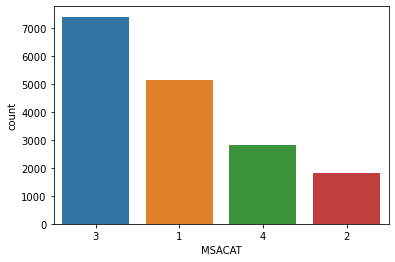

In [10]:
cleaned_ny['MSACAT'].value_counts()

cat_col_prop(cleaned_ny,'MSACAT')

       counts  percentage
XXXXX   10228   59.541274
35620    5142   29.933636
40380     963    5.606008
15380     845    4.919083


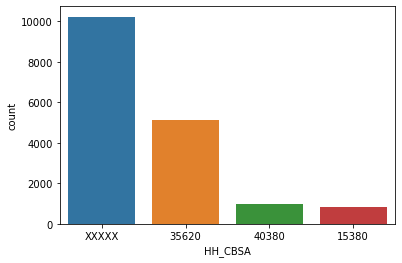

In [11]:
cleaned_ny['HH_CBSA'].value_counts()

cat_col_prop(cleaned_ny,'HH_CBSA')

   counts  percentage
5    5142   29.933636
1    4371   25.445337
6    2807   16.340668
3    2270   13.214577
4    1808   10.525090
2     780    4.540692


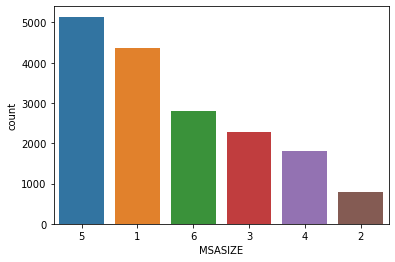

In [12]:
cleaned_ny['MSASIZE'].value_counts()

cat_col_prop(cleaned_ny,'MSASIZE')

    counts  percentage
23    7418   43.183141
21    5138   29.910350
24    2806   16.334847
22    1807   10.519269
51       3    0.017464
13       2    0.011643
31       1    0.005821
54       1    0.005821
52       1    0.005821
33       1    0.005821


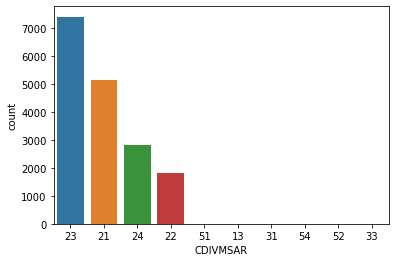

In [13]:
cleaned_ny['CDIVMSAR'].value_counts()

cat_col_prop(cleaned_ny,'CDIVMSAR')

HH_CBSA has more than 50% missing values and CDIVMSAR offers more granular information for location. Hence, CDVIMSAR will be selected.

In [14]:
cleaned_ny = cleaned_ny.drop(columns=['HH_CBSA','MSACAT','MSASIZE'])

#### Location-based Metrics: Internet Usage (SPHONE, TAB, WEBUSE17, PC)
There are 4 metrics to look at internet usage. We will take a look and see which one to use in the end.

    counts  percentage
 1   10615   61.794155
 5    4549   26.481546
 2     855    4.977297
-9     507    2.951450
 3     422    2.456631
 4     227    1.321458
-8       2    0.011643
-7       1    0.005821


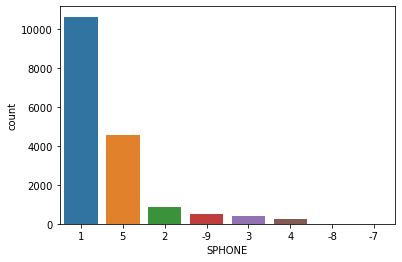

In [15]:
cleaned_ny['SPHONE'].value_counts()

cat_col_prop(cleaned_ny,'SPHONE')

    counts  percentage
 5    6661   38.776342
 1    5398   31.423914
 2    2130   12.399581
 3    1460    8.499243
 4     848    4.936547
-9     680    3.958552
-7       1    0.005821


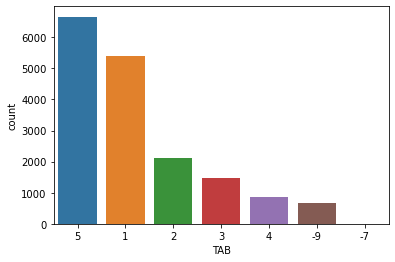

In [16]:
cleaned_ny['TAB'].value_counts()

cat_col_prop(cleaned_ny,'TAB')

    counts  percentage
 1   11987   69.781115
 2    1884   10.967517
 5    1844   10.734661
 3     760    4.424264
 4     381    2.217953
-9     322    1.874491


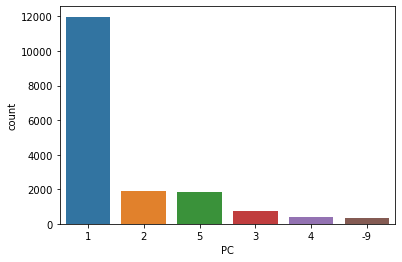

In [17]:
cleaned_ny['PC'].value_counts()

cat_col_prop(cleaned_ny,'PC')

    counts  percentage
 1   14645   85.254395
 5    1175    6.840144
 2     860    5.006404
 3     265    1.542671
 4     135    0.785889
-9      98    0.570497


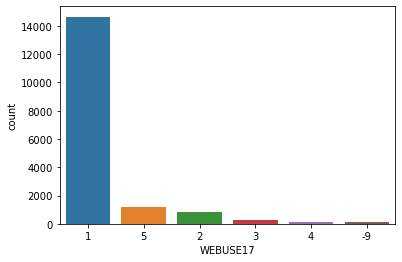

In [18]:
cleaned_ny['WEBUSE17'].value_counts()

cat_col_prop(cleaned_ny,'WEBUSE17')

All these columns are essentially talking about how the household access the internet. Hence, the overall metric, WEBUSE17 will be used. In addition, the distribution is quite skewed. Hence a possible binning will be done.

        counts  percentage
Daily    14645   85.254395
Rarely    1260    7.334963
Never     1175    6.840144
NA          98    0.570497


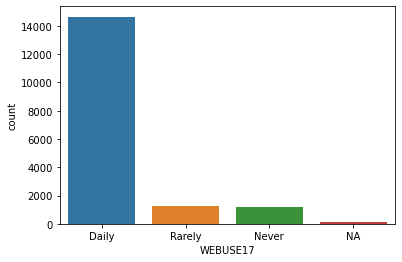

In [19]:
cleaned_ny['WEBUSE17'] = cleaned_ny['WEBUSE17'].replace({1:"Daily",
                                       2: "Rarely",
                                      3: "Rarely",
                                      4: "Rarely",
                                      5: "Never",                   
                                      -9: "NA",
                                      })
cat_col_prop(cleaned_ny,'WEBUSE17')

In [20]:
cleaned_ny = cleaned_ny.drop(columns=['TAB','PC','SPHONE'])

#### Question-based Feature: PRICE, PLACE, BIKE2SAVE, WALK2SAVE

These are questions that people answer that can possibly help shed some behaviour/decision choices for their household. it would be good to include it in the model.

    counts  percentage
3     5717   33.280941
2     5147   29.962743
4     3055   17.784375
1     1881   10.950052
5      973    5.664222
NA     405    2.357667


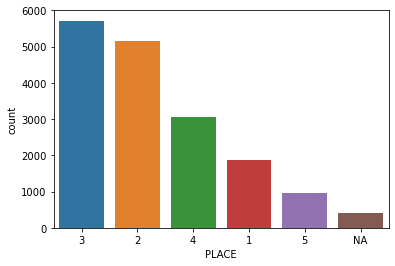

In [21]:
cleaned_ny['PLACE'].value_counts()
cleaned_ny['PLACE'] = cleaned_ny['PLACE'].replace({          
                                      -9: "NA"
                                      })
cat_col_prop(cleaned_ny,'PLACE')

    counts  percentage
5     6064   35.300966
4     4225   24.595413
3     3483   20.275934
2     1744   10.152521
1     1034    6.019327
NA     628    3.655839


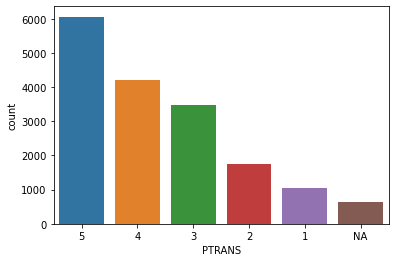

In [22]:
cleaned_ny['PTRANS'].value_counts()

cleaned_ny['PTRANS'] = cleaned_ny['PTRANS'].replace({                   
                                      -9: "NA",
                                      -7: "NA"})
cat_col_prop(cleaned_ny,'PTRANS')

    counts  percentage
2     4733   27.552684
3     3811   22.185353
4     3518   20.479683
1     2984   17.371056
5     1954   11.375015
NA     178    1.036209


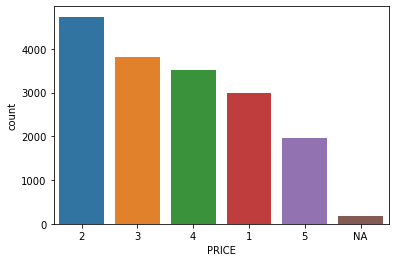

In [23]:
cleaned_ny['PRICE'].value_counts()

#cat_col_prop(cleaned_ny,'PRICE')

cleaned_ny['PRICE'] = cleaned_ny['PRICE'].replace({                   
                                      -9: "NA"
                                      })
cat_col_prop(cleaned_ny,'PRICE')

    counts  percentage
5     6935   40.371405
4     4631   26.958901
3     3564   20.747468
2      864    5.029689
NA     831    4.837583
1      353    2.054954


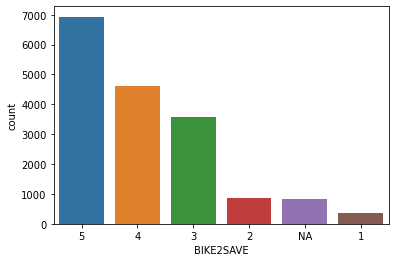

In [24]:
cleaned_ny['BIKE2SAVE'].value_counts()

#cat_col_prop(cleaned_ny,'BIKE2SAVE')

cleaned_ny['BIKE2SAVE'] = cleaned_ny['BIKE2SAVE'].replace({
                                      -7: "NA",
                                      -9: "NA"
                                      })
cat_col_prop(cleaned_ny,'BIKE2SAVE')

    counts  percentage
4     5163   30.055885
5     4535   26.400047
3     3477   20.241006
2     2398   13.959716
1     1014    5.902899
NA     591    3.440447


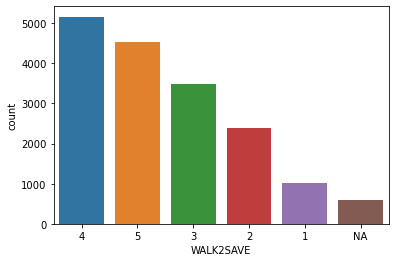

In [25]:
cleaned_ny['WALK2SAVE'].value_counts()

#cat_col_prop(cleaned_ny,'WALK2SAVE')

cleaned_ny['WALK2SAVE'] = cleaned_ny['WALK2SAVE'].replace({
                                      -7: "NA",
                                      -9: "NA"
                                      })
cat_col_prop(cleaned_ny,'WALK2SAVE')

These metrics will be used, wth the negative values being replaced as NA.

#### Measure of Urbanness: URBAN, URBANSIZE, URBAN
These features measure the urbanness of the households. 

   counts  percentage
1    9982   58.109209
4    5357   31.185237
2    1836   10.688089
3       3    0.017464


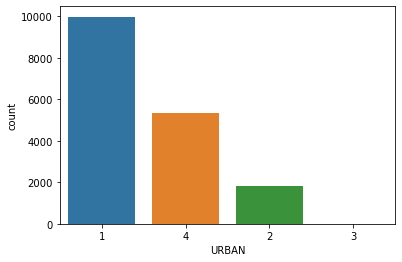

In [26]:
cleaned_ny['URBAN'].value_counts()

cat_col_prop(cleaned_ny,'URBAN')

   counts  percentage
1   11818   68.797299
2    5360   31.202701


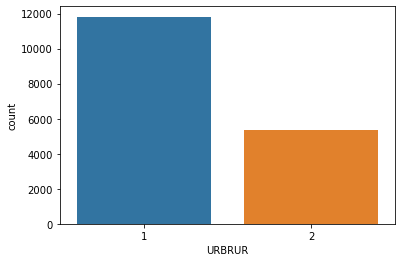

In [27]:
cleaned_ny['URBRUR'].value_counts()

cat_col_prop(cleaned_ny,'URBRUR')

   counts  percentage
6    7196   41.890791
5    3486   20.293399
1    2795   16.270812
3    2002   11.654442
2    1699    9.890558


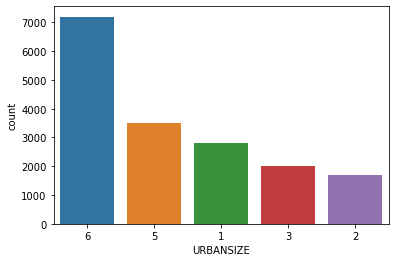

In [28]:
cleaned_ny['URBANSIZE'].value_counts()

cat_col_prop(cleaned_ny,'URBANSIZE')

Based on the distribution, URBAN has more granular categorical information regarding where the household is based at. Although URBANSIZE might have more feature defintions, it is referring to the size, which makes it hard to ascertain. However, both features are talking about different features of urbanness. Hence, we will keep both at the moment. On the other hand, URBRUR will be dropped first.

In [29]:
cleaned_ny = cleaned_ny.drop(columns=['URBRUR'])

In [30]:
corr,_ = pearsonr(cleaned_ny['URBAN'],cleaned_ny['URBANSIZE'])
print("Pearson Corelation of: ",str(corr), "between URBAN and URBANSIZE. May remove one if too many variables")

Pearson Corelation of:  0.6974092332818764 between URBAN and URBANSIZE. May remove one if too many variables


In [31]:
# Intermediary check
cleaned_ny.head(3).append(cleaned_ny.tail(3))

,HOUSEID,TRAVDAY,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,WALK,BIKE,TAXI,BUS,TRAIN,PARA,PRICE,PLACE,WALK2SAVE,BIKE2SAVE,PTRANS,HHRELATD,DRVRCNT,CNTTDHH,HHSTFIPS,NUMADLT,YOUNGCHILD,WRKCOUNT,LIF_CYC,RAIL,URBAN,URBANSIZE,CDIVMSAR,HH_RACE,HH_HISP,WEBUSE17,SMPLSRCE
2,30000012,5,1,1,2,10,2,5,5,4,4,5,2,1,2,3,5,2,1,9,36,1,0,1,1,2,1,3,23,1,2,Daily,2
8,30000082,3,2,4,2,8,-9,5,5,5,5,5,3,3,5,5,5,1,2,12,36,2,2,2,4,2,1,3,23,1,2,Daily,2
15,30000130,1,1,2,1,5,-9,-9,-9,1,1,-9,1,1,1,NA,1,1,2,4,36,2,0,2,2,1,1,5,21,1,2,Daily,1
129662,40793974,3,2,1,1,3,2,5,5,5,5,5,1,2,3,3,3,2,1,7,36,1,0,0,9,2,1,1,23,1,2,Daily,2
129668,40794020,3,1,2,4,8,4,5,5,4,5,5,2,2,5,5,5,1,2,11,36,2,0,0,10,2,4,6,24,1,2,Daily,2
129689,40794249,2,2,1,0,2,4,5,5,5,5,5,3,3,3,5,5,2,1,2,36,1,0,0,9,2,2,6,23,1,2,Never,2


#### Household Indicators: NUMADLT, YOUNGCHILD, LIF_CYC, HOMEOWN, HH_HISP, HH_RACE, HH_FAMINC, DRVRCNT, WRKCOUNT

We will look into the household indicators for the households.

          counts  percentage
1.000000   12090   70.380720
0.500000    1831   10.658982
0.000000    1072    6.240540
0.666667    1020    5.937827
0.333333     291    1.694027
0.750000     269    1.565956
0.400000     261    1.519385
0.600000      95    0.553033
0.250000      80    0.465712
0.800000      60    0.349284
0.200000      29    0.168821
0.428571      14    0.081500
0.285714      14    0.081500
0.166667      11    0.064035
0.833333       9    0.052393
0.571429       7    0.040750
0.142857       5    0.029107
0.375000       5    0.029107
0.222222       3    0.017464
0.714286       3    0.017464
0.300000       2    0.011643
0.125000       1    0.005821
0.555556       1    0.005821
0.111111       1    0.005821
0.625000       1    0.005821
0.272727       1    0.005821
0.700000       1    0.005821
0.857143       1    0.005821


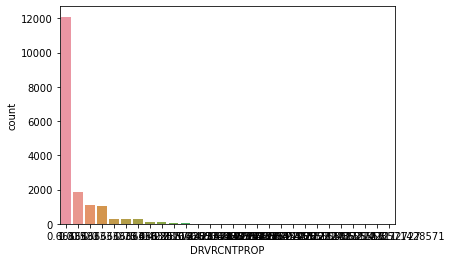

In [32]:
# DRVRCNT - we will use HHSIZE throughout
cleaned_ny['DRVRCNTPROP'] = cleaned_ny['DRVRCNT']/cleaned_ny['HHSIZE']
cat_col_prop(cleaned_ny,'DRVRCNTPROP')

   counts  percentage
2    8271   48.148795
1    6272   36.511817
3    1194    6.950751
0    1072    6.240540
4     317    1.845384
5      44    0.256142
6       7    0.040750
7       1    0.005821


Text(0.5, 1.0, 'Number of Drivers')

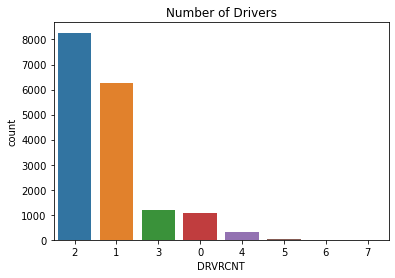

In [33]:
cat_col_prop(cleaned_ny,'DRVRCNT')
plt.title('Number of Drivers')

Pearson Corelation of:  0.8130556250300681 between DRVRCNT and NUMADLT. May remove one if too many variables


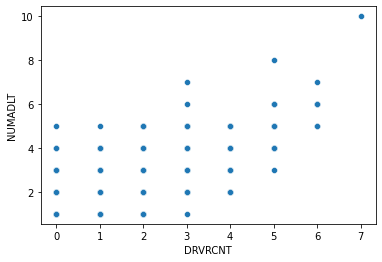

In [34]:
#number of drivers in the household compare with Adults
corr,_ = pearsonr(cleaned_ny['DRVRCNT'],cleaned_ny['NUMADLT'])
print("Pearson Corelation of: ",str(corr), "between DRVRCNT and NUMADLT. May remove one if too many variables")
sns.scatterplot(x = cleaned_ny['DRVRCNT'], y = cleaned_ny['NUMADLT'])

In [35]:
# will bin those with >2 drivers together
cleaned_ny['DRVRCNT'][cleaned_ny['DRVRCNT']>2] = ">2"

print("_______________________")
print("new value counts for DRVRCNT")

print(pd.concat([cleaned_ny['DRVRCNT'].value_counts(),
          cleaned_ny['DRVRCNT'].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage')))

_______________________
new value counts for DRVRCNT
    counts  percentage
2     8271   48.148795
1     6272   36.511817
>2    1563    9.098847
0     1072    6.240540


    counts  percentage
 2   16507   96.093841
 1     634    3.690767
-7      37    0.215392
     counts  percentage
 1    15333   89.259518
 2      672    3.911980
 3      460    2.677844
 6      340    1.979276
 97     199    1.158458
-7       88    0.512283
 4       59    0.343463
 5       14    0.081500
-8       13    0.075678


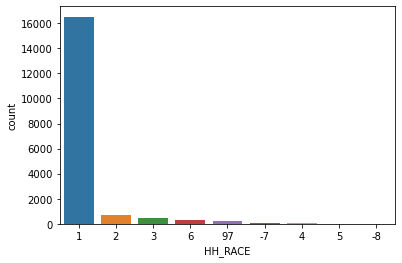

In [36]:
# looking at race level 
cat_col_prop(cleaned_ny,'HH_HISP')
cat_col_prop(cleaned_ny,'HH_RACE')

From this we can see that almost all of the households are 1, which is yes and white respectively. This is very skewed and will be dropped.

In [37]:
cleaned_ny = cleaned_ny.drop(columns=['HH_HISP','HH_RACE'])

           counts  percentage
HOME_OWN    13115   76.347654
HOME_RENT    3933   22.895564
NA            130    0.756782


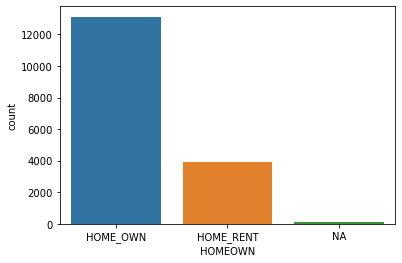

In [38]:
#cat_col_prop(cleaned_ny,'HOMEOWN') - replace negative values with NA

cleaned_ny['HOMEOWN'] = cleaned_ny['HOMEOWN'].replace({1:"HOME_OWN",
                                       2: "HOME_RENT",
                                      97: "NA",
                                      -7: "NA"})

cat_col_prop(cleaned_ny,'HOMEOWN')

    counts  percentage
6     2975   17.318663
7     2260   13.156363
5     1982   11.538014
8     1712    9.966236
4     1583    9.215275
3     1475    8.586564
9      981    5.710793
11     967    5.629293
10     911    5.303295
2      859    5.000582
1      827    4.814297
NA     646    3.760624


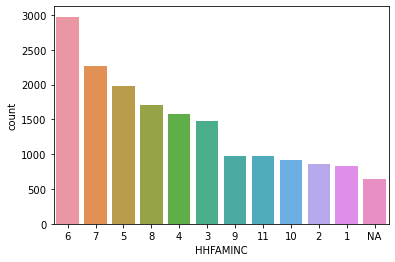

In [39]:
#cat_col_prop(cleaned_ny,'HHFAMINC')
cleaned_ny['HHFAMINC'][cleaned_ny['HHFAMINC'].isin([-9,-8,-7])]  = "NA"

cat_col_prop(cleaned_ny,'HHFAMINC')

   counts  percentage
0    6280   36.558389
1    5785   33.676796
2    4354   25.346373
3     602    3.504482
4     143    0.832460
5      12    0.069857
7       1    0.005821
6       1    0.005821
      counts  percentage
0       6280   36.558389
1       5303   30.870881
>0.5    4126   24.019094
<0.5    1469    8.551636


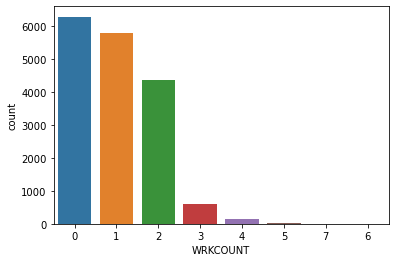

In [40]:
#Proportion of workers in the household 
#0 makes up nearly 34% - meaning they are all retired?
cat_col_prop(cleaned_ny,'WRKCOUNT')

cleaned_ny['WRKCOUNT'] = cleaned_ny['WRKCOUNT']/cleaned_ny['HHSIZE']

#Bin to groups
cleaned_ny['WRKCOUNT_ratio'] = 'NA'
cleaned_ny.loc[cleaned_ny['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
cleaned_ny.loc[cleaned_ny['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = '<0.5'
cleaned_ny.loc[cleaned_ny['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = '>0.5'
cleaned_ny.loc[cleaned_ny['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

print(pd.concat([cleaned_ny['WRKCOUNT_ratio'].value_counts(),
          cleaned_ny['WRKCOUNT_ratio'].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage'))
     )

    counts  percentage
2     9215   53.644196
1     6152   35.813250
3     1374    7.998603
4      358    2.084061
5       67    0.390034
6        8    0.046571
7        2    0.011643
10       1    0.005821
8        1    0.005821


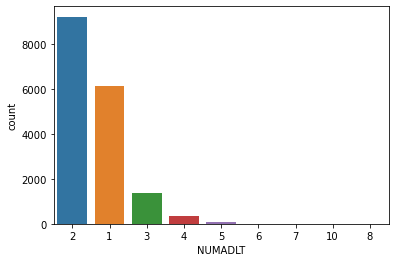

In [41]:
#Proportion of adults in a family 
cat_col_prop(cleaned_ny,'NUMADLT')

cleaned_ny['NUMADLT'] = cleaned_ny['NUMADLT']/cleaned_ny['HHSIZE']

#Bin into groups
cleaned_ny['NUMADLT_ratio'] = 'NA'

cleaned_ny.loc[cleaned_ny['NUMADLT']==0,'NUMADLT_ratio']= '0'
cleaned_ny.loc[cleaned_ny['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = '<0.5'
cleaned_ny.loc[cleaned_ny['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = '>0.5'
cleaned_ny.loc[cleaned_ny['NUMADLT']==1,'NUMADLT_ratio'] ='1'
 
#about 80% of families comprises of adults 

      counts  percentage
1      14098   82.070090
>0.5    2528   14.716498
<0.5     552    3.213413


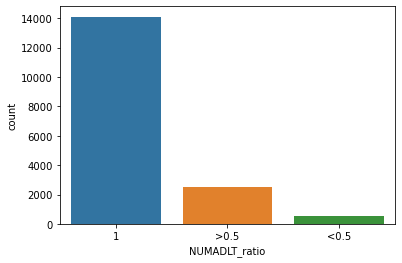

In [42]:
cat_col_prop(cleaned_ny,'NUMADLT_ratio')

   counts  percentage
1   11189   65.135639
2    5989   34.864361


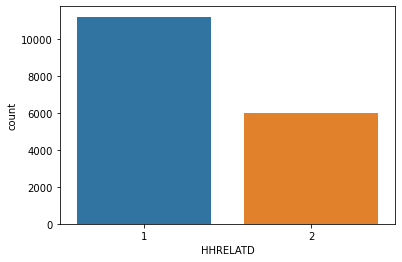

In [43]:
cat_col_prop(cleaned_ny,'HHRELATD')

    counts  percentage
10    4296   25.008732
2     3577   20.823146
1     3120   18.162766
9     2649   15.420887
6     1254    7.300035
4     1127    6.560717
8      621    3.615089
5      267    1.554314
7      156    0.908138
3      111    0.646175


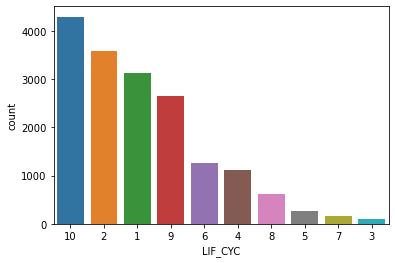

In [44]:
cat_col_prop(cleaned_ny,'LIF_CYC')

In [45]:
# cleaned_ny['LIF_CYC'] = cleaned_ny['LIF_CYC'].replace({
# 1:'1 adult+no kids',
# 2:'2+ adults+no kids',
# 3:'1 adult+youngest 0-5',
# 4:'2+ adults+youngest 0-5',
# 5:'one adults+youngest 6-15',
# 6:'2+ adults+youngest 6-15',
# 7:'one adult+youngest 16-21',
# 8:'2+ adults+youngest 16-21',
# 9:'1 retired+no kids',
# 10:'2+ retired+no kids'})
# plt.title('Life Cycle')
# cat_col_prop(cleaned_ny,'LIF_CYC') 
# plt.xticks(rotation=40)

      counts  percentage
0      16093   93.683782
<0.5     858    4.994761
>0.5     227    1.321458


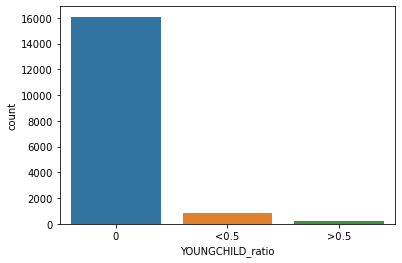

In [46]:
#proportion of family with children
cleaned_ny['YOUNGCHILD'] = cleaned_ny['YOUNGCHILD']/cleaned_ny['HHSIZE']

#Bin to groups
cleaned_ny['YOUNGCHILD_ratio'] = 'NA'
cleaned_ny.loc[cleaned_ny['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
cleaned_ny.loc[cleaned_ny['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = '<0.5'
cleaned_ny.loc[cleaned_ny['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = '>0.5'
cleaned_ny.loc[cleaned_ny['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'

cat_col_prop(cleaned_ny,'YOUNGCHILD_ratio')

    counts  percentage
2     7218   42.018861
1     5769   33.583654
>2    4191   24.397485


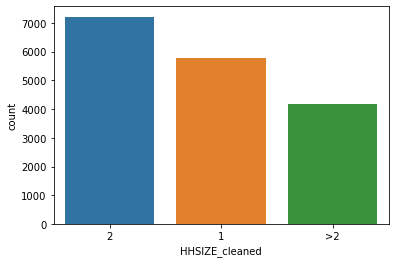

In [47]:
# Household size 
cleaned_ny['HHSIZE_cleaned'] = cleaned_ny['HHSIZE'].replace({
                                      3:">2",
                                      4:">2",
                                      5:">2",
                                      6:">2",
    7:">2",
    8:">2",
    9:">2",
    10:">2",
    11:">2"
                                      })
cat_col_prop(cleaned_ny,'HHSIZE_cleaned')

Most of the household indicators can be useful in determining vehicle ownership. Hence, some of these will be binned as well with most of the values being kept.

#### Travel Indicators - BIKE, PARA, WALK, BUS, RAIL

This will shed some light on the public transport usage for the households.

   counts  percentage
2   12036   70.066364
1    5142   29.933636


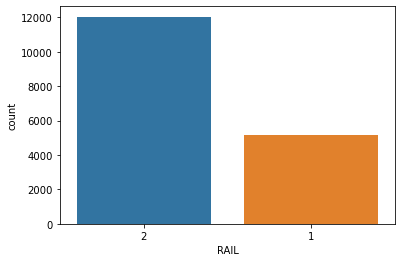

In [48]:
cat_col_prop(cleaned_ny,'RAIL')

    counts  percentage
 5   10770   62.696472
 4    2717   15.816742
-9    1882   10.955874
 3     969    5.640936
 2     636    3.702410
 1     204    1.187565
        counts  percentage
Never    10770   62.696472
Rarely    4322   25.160088
NA        1882   10.955874
Daily      204    1.187565


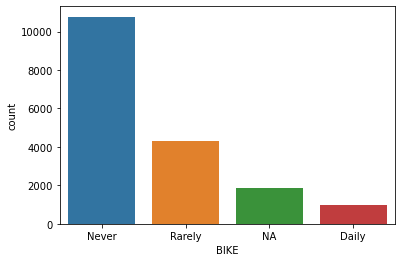

In [49]:
cat_col_prop(cleaned_ny,'BIKE')

cleaned_ny['BIKE'] = cleaned_ny['BIKE'].replace({1:"Daily",
                                       2: "Rarely",
                                      3: "Rarely",
                                      4: "Rarely",
                                      5: "Never",                   
                                      -9: "NA",
                                      })
cat_col_prop(cleaned_ny,'BIKE')

    counts  percentage
 5   14676   85.434859
-9    2117   12.323903
 4     234    1.362207
 3      78    0.454069
 2      41    0.238677
 1      25    0.145535
-8       4    0.023286
-7       3    0.017464


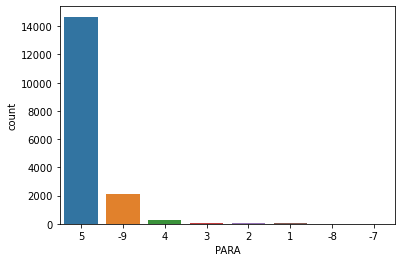

In [50]:
cat_col_prop(cleaned_ny,'PARA') # will drop as it is not a common mode of travel

In [51]:
cleaned_ny = cleaned_ny.drop(columns=['PARA'])

    counts  percentage
 1    3831   22.301781
 5    3576   20.817324
 2    2989   17.400163
 4    2973   17.307021
 3    2443   14.221679
-9    1366    7.952032
    counts  percentage
1     3831   22.301781
5     3576   20.817324
2     2989   17.400163
4     2973   17.307021
3     2443   14.221679
NA    1366    7.952032


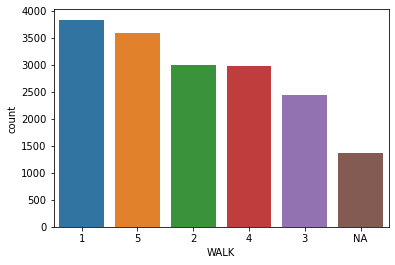

In [52]:
cat_col_prop(cleaned_ny,'WALK')
# quite well spread, no need to bin
cleaned_ny['WALK'] = cleaned_ny['WALK'].replace({-9:"NA"})
cat_col_prop(cleaned_ny,'WALK')

In [53]:
# drop travday, smplsrce, drvrntcnt, hhstfips
#cleaned_ny = cleaned_ny.drop(columns=['TRAVDAY','SMPLSRCE','DRVRCNT'])

# convert vehcnt to binary for target variable
cleaned_ny['VEHOWN'] = cleaned_ny['HHVEHCNT'].apply(lambda x: 1 if x > 0 else 0)

In [54]:
# drop vehcnt 
cleaned_ny = cleaned_ny.drop(columns=['HHVEHCNT','HHSTFIPS'])
cleaned_ny = cleaned_ny.drop(columns=['HHSIZE'])

### 2. Person Dataset

In [57]:
#personal = pd.read_csv('./data/perpub.csv')
personal =  pd.read_csv("".join([path,'/perpub.csv']))
NY_HH_IDS = NY_households['HOUSEID'].values.tolist()
NY_personal = personal[personal['HOUSEID'].isin(NY_HH_IDS)] # filter to NY Households 
NY_personal.head(3).append(NY_personal.tail(3))

,HOUSEID,PERSONID,R_AGE,EDUC,R_HISP,R_RELAT,R_SEX,R_RACE,PRMACT,PAYPROF,GT1JBLWK,WRK_HOME,WKFTPT,WRKTRANS,LSTTRDAY17,OCCAT,SCHTYP,NWALKTRP,WALK4EX,NBIKETRP,BIKE4EX,BIKESHARE,PTUSED,MCUSED,CARSHARE,RIDESHARE,CARRODE,TIMETOWK,NOCONG,PUBTIME,WRKTIME,WKRMHM,FLEXTIME,WKFMHMXX,SCHTRN1,SCHTRN2,DELIVER,MEDCOND,MEDCOND6,HEALTH,PHYACT,VPACT,LPACT,BORNINUS,YRTOUS,YEARMILE,PROXY,WHOPROXY,USEPUBTR,SAMEPLC,W_NONE,W_CANE,W_WLKR,W_WHCANE,W_DOG,W_CRUTCH,W_SCOOTR,W_CHAIR,W_MTRCHR,WORKER,DIARY,OUTCNTRY,FRSTHM17,CNTTDTR,GCDWORK,WKSTFIPS,DRIVER,OUTOFTWN,DISTTOWK17,DISTTOSC17,R_AGE_IMP,R_SEX_IMP,ALT_16,ALT_23,ALT_45,WALK_DEF,WALK_GKQ,BIKE_DFR,BIKE_GKP,CONDTRAV,CONDRIDE,CONDNIGH,CONDRIVE,CONDPUB,CONDSPEC,CONDTAX,TRAVDAY,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,HHSTATE,HHSTFIPS,NUMADLT,WRKCOUNT,TDAYDATE,HHRESP,LIF_CYC,MSACAT,MSASIZE,RAIL,URBAN,URBANSIZE,URBRUR,CENSUS_D,CENSUS_R,CDIVMSAR,HH_RACE,HH_HISP,HH_CBSA,SMPLSRCE,WTPERFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
5,30000012,1,45,5,2,1,2,1,1,-1,2,2,1,3,-1,4,-1,6,6,0,-1,-1,0,-1,0,0,1,30,12,-1,07:30 AM,2,2,-1,-1,-1,5,2,-1,2,3,7,-1,1,-1,17000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,2,1,9,4.60,36,1,2,6.82,-9.0,45,2,3,1,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5,1,1,2,10,1,NY,36,1,1,201607,1,1,3,3,2,1,3,1,2,1,23,1,2,XXXXX,2,58.966275,C,80,17000,17000,5000,60,17000,7000
16,30000082,1,39,5,2,1,2,1,1,-1,2,2,1,3,-1,2,-1,3,2,0,-1,-1,0,-1,0,0,1,4,3,-1,08:30 AM,1,1,2,-1,-1,3,2,-1,2,2,-1,2,1,-1,8000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,2,1,5,1.04,36,1,2,1.65,-9.0,39,2,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,2,4,2,8,2,NY,36,2,2,201605,1,4,3,3,2,1,3,1,2,1,23,1,2,XXXXX,2,1028.814768,T,20,1500,300,750,30,750,300
17,30000082,2,38,4,2,2,1,1,1,-1,2,2,1,3,-1,4,-1,0,-1,0,-1,-1,0,-1,0,0,1,42,36,-1,08:45 AM,1,2,2,-1,-1,5,2,-1,2,2,-1,2,1,-1,15000,1,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,2,1,7,24.35,36,1,2,30.04,-9.0,38,1,3,1,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,2,4,2,8,2,NY,36,2,2,201605,1,4,3,3,2,1,3,1,2,1,23,1,2,XXXXX,2,1296.339345,T,20,1500,300,750,30,750,300
264175,40794020,1,75,3,2,1,1,1,6,2,-1,-1,-1,-1,-1,-1,-1,7,0,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,-1,2,2,-1,4,1,-1,7000,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,2,1,6,-9.00,-9,1,2,-9.00,-9.0,75,1,4,1,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,1,2,4,8,2,NY,36,2,0,201702,1,10,4,6,2,4,6,2,2,1,24,1,2,XXXXX,2,58.188893,R,5,50,50,25,5,50,50
264176,40794020,2,70,2,2,2,2,1,6,2,-1,-1,-1,-1,-1,-1,-1,7,0,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4,2,-1,3,2,-1,7,1,-1,13000,1,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,2,1,5,-9.00,-9,1,2,-9.00,-9.0,70,2,4,1,4,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,1,2,4,8,2,NY,36,2,0,201702,1,10,4,6,2,4,6,2,2,1,24,1,2,XXXXX,2,62.285639,R,5,50,50,25,5,50,50
264217,40794249,1,80,2,2,1,2,1,6,2,-1,-1,-1,-1,-1,-1,-1,7,7,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,2,3,2,-1,7,1,-1,-88,1,1,2,-1,-1,1,2,-1,-1,-1,-1,-1,-1,2,1,2,1,2,-9.00,-9,1,2,-9.00,-9.0,80,2,4,4,4,-1,-1,-1,-1,1,1,2,2,2,2,2,2,2,1,0,2,1,NY,36,1,0,201702,1,9,3,2,2,2,6,1,2,1,23,1,2,XXXXX,2,48.507742,-9,-9,-9,-9,-9,-9,-9,-9


#### Removal of Features mentioned in the Analysis of Household Dataset

For the 1st round of dropping, variables that were mentioned previously to be dropped in the Household datasey will be dropped first. In addition, those features that were previously in the household set will be dropped as well.

In [58]:
cleaned_person = NY_personal.drop(columns=['CENSUS_D', 'CENSUS_R', 'HBHTNRNT', 'HBHUR', 'HBPPOPDN', 'HBRESDN', 'HHRESP', 'HHSTATE','HTEEMPDN','HH_HISP','HHSTFIPS','RAIL','HTHTNRNT', 'HTPPOPDN', 'HTRESDN','R_HISP','R_RACE','URBAN','URBANSIZE','URBRUR','R_RELAT','CDIVMSAR','HH_RACE','HOMEOWN','LIF_CYC','BORNINUS','HHRESP','WRKCOUNT','NUMADLT','WHOPROXY','USEPUBTR','PROXY'])
cleaned_person.head(3).append(cleaned_person.tail(3))

,HOUSEID,PERSONID,R_AGE,EDUC,R_SEX,PRMACT,PAYPROF,GT1JBLWK,WRK_HOME,WKFTPT,WRKTRANS,LSTTRDAY17,OCCAT,SCHTYP,NWALKTRP,WALK4EX,NBIKETRP,BIKE4EX,BIKESHARE,PTUSED,MCUSED,CARSHARE,RIDESHARE,CARRODE,TIMETOWK,NOCONG,PUBTIME,WRKTIME,WKRMHM,FLEXTIME,WKFMHMXX,SCHTRN1,SCHTRN2,DELIVER,MEDCOND,MEDCOND6,HEALTH,PHYACT,VPACT,LPACT,YRTOUS,YEARMILE,SAMEPLC,W_NONE,W_CANE,W_WLKR,W_WHCANE,W_DOG,W_CRUTCH,W_SCOOTR,W_CHAIR,W_MTRCHR,WORKER,DIARY,OUTCNTRY,FRSTHM17,CNTTDTR,GCDWORK,WKSTFIPS,DRIVER,OUTOFTWN,DISTTOWK17,DISTTOSC17,R_AGE_IMP,R_SEX_IMP,ALT_16,ALT_23,ALT_45,WALK_DEF,WALK_GKQ,BIKE_DFR,BIKE_GKP,CONDTRAV,CONDRIDE,CONDNIGH,CONDRIVE,CONDPUB,CONDSPEC,CONDTAX,TRAVDAY,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,TDAYDATE,MSACAT,MSASIZE,HH_CBSA,SMPLSRCE,WTPERFIN
5,30000012,1,45,5,2,1,-1,2,2,1,3,-1,4,-1,6,6,0,-1,-1,0,-1,0,0,1,30,12,-1,07:30 AM,2,2,-1,-1,-1,5,2,-1,2,3,7,-1,-1,17000,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,2,1,9,4.60,36,1,2,6.82,-9.0,45,2,3,1,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5,1,2,10,1,201607,3,3,XXXXX,2,58.966275
16,30000082,1,39,5,2,1,-1,2,2,1,3,-1,2,-1,3,2,0,-1,-1,0,-1,0,0,1,4,3,-1,08:30 AM,1,1,2,-1,-1,3,2,-1,2,2,-1,2,-1,8000,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,2,1,5,1.04,36,1,2,1.65,-9.0,39,2,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,4,2,8,2,201605,3,3,XXXXX,2,1028.814768
17,30000082,2,38,4,1,1,-1,2,2,1,3,-1,4,-1,0,-1,0,-1,-1,0,-1,0,0,1,42,36,-1,08:45 AM,1,2,2,-1,-1,5,2,-1,2,2,-1,2,-1,15000,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,2,1,7,24.35,36,1,2,30.04,-9.0,38,1,3,1,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,4,2,8,2,201605,3,3,XXXXX,2,1296.339345
264175,40794020,1,75,3,1,6,2,-1,-1,-1,-1,-1,-1,-1,7,0,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,-1,2,2,-1,4,-1,7000,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,2,1,6,-9.00,-9,1,2,-9.00,-9.0,75,1,4,1,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,2,4,8,2,201702,4,6,XXXXX,2,58.188893
264176,40794020,2,70,2,2,6,2,-1,-1,-1,-1,-1,-1,-1,7,0,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4,2,-1,3,2,-1,7,-1,13000,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,2,1,5,-9.00,-9,1,2,-9.00,-9.0,70,2,4,1,4,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,2,4,8,2,201702,4,6,XXXXX,2,62.285639
264217,40794249,1,80,2,2,6,2,-1,-1,-1,-1,-1,-1,-1,7,7,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,2,3,2,-1,7,-1,-88,-1,-1,1,2,-1,-1,-1,-1,-1,-1,2,1,2,1,2,-9.00,-9,1,2,-9.00,-9.0,80,2,4,4,4,-1,-1,-1,-1,1,1,2,2,2,2,2,2,1,0,2,1,201702,3,2,XXXXX,2,48.507742


In [59]:
# features relating to trip diary or a trip component
# for this, features relating to trip diary will be dropped as well.
# in addition, questions relating to a trip component will be dropped

cleaned_person = cleaned_person.drop(columns=['SMPLSRCE','SAMEPLC','HHFAMINC','HHVEHCNT','BIKE_DFR','BIKE_GKP','DIARY','DRIVER','DRVRCNT','OUTCNTRY','OUTOFTWN','PAYPROF','PRMACT','TDAYDATE','WALK4EX','WALK_DEF','WALK_GKQ','YEARMILE','YRTOUS','WTPERFIN','DELIVER','DRVRCNT','LSTTRDAY17','FRSTHM17','MSACAT','MSASIZE','HH_CBSA'])

#### Metrics on Medical Condition - COND series, W Series, Health

There are some questions on the medical status of the households. This can be further explored. For the mode of medical device used, it is not useful so it will be dropped.

    counts  percentage
-1   29831   86.396548
 2    3408    9.870250
 1    1288    3.730306
-9       1    0.002896
    counts  percentage
-1   29831   86.396548
 2    4413   12.780931
 1     283    0.819625
-9       1    0.002896
    counts  percentage
 2   31106   90.089203
 1    3403    9.855769
-8      10    0.028962
-7       9    0.026066


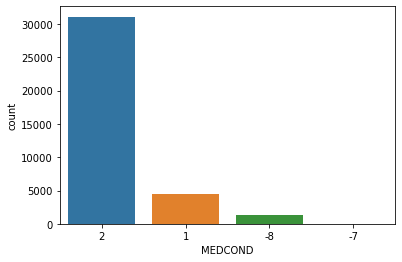

In [60]:
cleaned_person = cleaned_person.drop(columns=['W_CANE','W_CHAIR','W_CRUTCH','W_DOG', 'W_MTRCHR','W_NONE','W_SCOOTR','W_WHCANE','W_WLKR'])   

cat_col_prop(cleaned_person,'CONDNIGH')
cat_col_prop(cleaned_person,'CONDSPEC')
cat_col_prop(cleaned_person,'MEDCOND')


A majority of responses for Medical Condition is mostly -1, which is 'appropriate skip'. Hence these features will be dropped.

In [61]:
#checked by jiaqi
cleaned_person = cleaned_person.drop(columns=['BIKESHARE', 'CARRODE','CARSHARE','DISTTOSC17','MCUSED','NBIKETRP','WKFMHMXX'])
cleaned_person.head(3).append(cleaned_person.tail(3))

,HOUSEID,PERSONID,R_AGE,EDUC,R_SEX,GT1JBLWK,WRK_HOME,WKFTPT,WRKTRANS,OCCAT,SCHTYP,NWALKTRP,BIKE4EX,PTUSED,RIDESHARE,TIMETOWK,NOCONG,PUBTIME,WRKTIME,WKRMHM,FLEXTIME,SCHTRN1,SCHTRN2,MEDCOND,MEDCOND6,HEALTH,PHYACT,VPACT,LPACT,WORKER,CNTTDTR,GCDWORK,WKSTFIPS,DISTTOWK17,R_AGE_IMP,R_SEX_IMP,ALT_16,ALT_23,ALT_45,CONDTRAV,CONDRIDE,CONDNIGH,CONDRIVE,CONDPUB,CONDSPEC,CONDTAX,TRAVDAY,HHSIZE
5,30000012,1,45,5,2,2,2,1,3,4,-1,6,-1,0,0,30,12,-1,07:30 AM,2,2,-1,-1,2,-1,2,3,7,-1,1,9,4.60,36,6.82,45,2,3,1,3,-1,-1,-1,-1,-1,-1,-1,5,1
16,30000082,1,39,5,2,2,2,1,3,2,-1,3,-1,0,0,4,3,-1,08:30 AM,1,1,-1,-1,2,-1,2,2,-1,2,1,5,1.04,36,1.65,39,2,1,1,2,-1,-1,-1,-1,-1,-1,-1,3,4
17,30000082,2,38,4,1,2,2,1,3,4,-1,0,-1,0,0,42,36,-1,08:45 AM,1,2,-1,-1,2,-1,2,2,-1,2,1,7,24.35,36,30.04,38,1,3,1,3,-1,-1,-1,-1,-1,-1,-1,3,4
264175,40794020,1,75,3,1,-1,-1,-1,-1,-1,-1,7,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,2,-1,2,2,-1,4,2,6,-9.00,-9,-9.00,75,1,4,1,4,-1,-1,-1,-1,-1,-1,-1,3,2
264176,40794020,2,70,2,2,-1,-1,-1,-1,-1,-1,7,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,2,-1,3,2,-1,7,2,5,-9.00,-9,-9.00,70,2,4,1,4,-1,-1,-1,-1,-1,-1,-1,3,2
264217,40794249,1,80,2,2,-1,-1,-1,-1,-1,-1,7,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,1,2,3,2,-1,7,2,2,-9.00,-9,-9.00,80,2,4,4,4,1,1,2,2,2,2,2,2,1


   counts  percentage
2   18165   52.609476
1   16363   47.390524


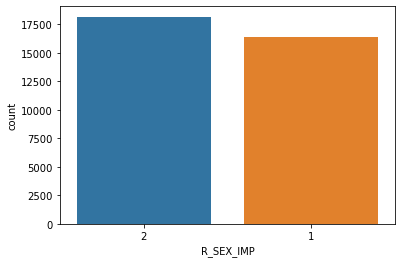

In [62]:
# Check Gender & Age
# cat_col_prop(cleaned_person,'R_AGE')
#cat_col_prop(cleaned_person,'R_AGE_IMP')
cat_col_prop(cleaned_person,'R_SEX_IMP')

For age, gender, the _impute do not have NA values, hence these columns will be used for the aggregation. Mean will be used for the age, while a gender ratio will be used for R_SEX_IMP

#### Mean Age - Metric 1

           counts  percentage
65.000000     330    1.921062
64.000000     308    1.792991
67.000000     305    1.775527
66.000000     305    1.775527
68.000000     292    1.699849
...           ...         ...
13.333333       1    0.005821
17.800000       1    0.005821
55.750000       1    0.005821
15.428571       1    0.005821
34.166667       1    0.005821

[518 rows x 2 columns]


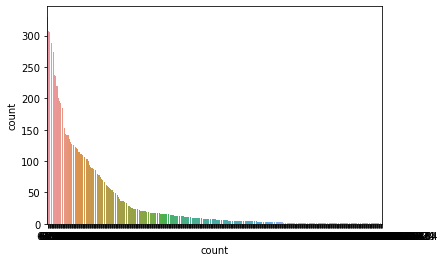

In [63]:
#cleaned_person = cleaned_person.drop(columns=['R_AGE','R_SEX'])
# mean_age
mean_age = cleaned_person.groupby(['HOUSEID'])["R_AGE_IMP"].mean().reset_index(name="count")
mean_age

cat_col_prop(mean_age, 'count')
# have to bin it

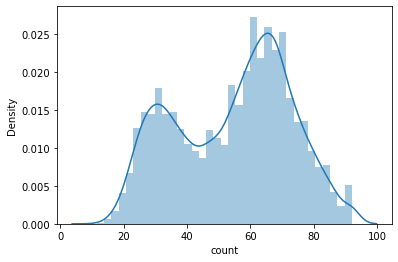

In [64]:
sns.distplot(mean_age['count'])

#### Percentage of Male Adults - Metric 2

          counts  percentage
0.500000    7236   54.951397
1.000000    2548   19.349939
0.333333    1206    9.158566
0.666667     816    6.196841
0.250000     523    3.971750
0.750000     268    2.035237
0.400000     207    1.571993
0.600000     125    0.949271
0.200000     109    0.827764
0.800000      44    0.334143
0.166667      19    0.144289
0.285714      17    0.129101
0.428571      11    0.083536
0.571429       9    0.068348
0.375000       7    0.053159
0.833333       5    0.037971
0.714286       5    0.037971
0.142857       4    0.030377
0.625000       3    0.022783
0.300000       1    0.007594
0.222222       1    0.007594
0.363636       1    0.007594
0.555556       1    0.007594
0.857143       1    0.007594
0.444444       1    0.007594


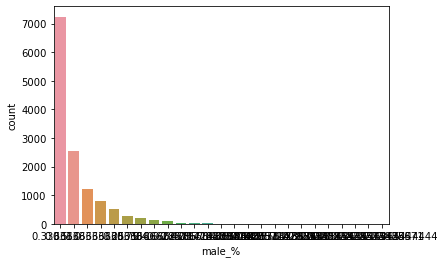

In [65]:
# gender ratio - % male adults 
male = cleaned_person.groupby(['HOUSEID','R_SEX_IMP','HHSIZE'])["R_SEX_IMP"].count().reset_index(name="count") # get the gender size
male = male[male['R_SEX_IMP'] == 1]
male['male_%'] = male['count']/male['HHSIZE']
cat_col_prop(male,'male_%')

      counts  percentage
0.5     7236   54.951397
1       2548   19.349939
<0.5    2107   16.000911
>0.5    1277    9.697752


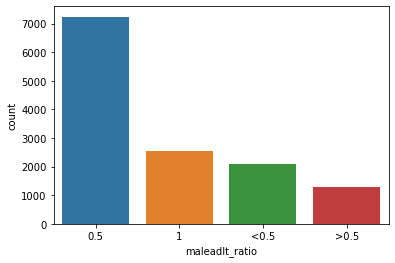

In [66]:
male['maleadlt_ratio'] = 'NA'
male.loc[male['male_%'].between(0,0.5,inclusive = False),'maleadlt_ratio'] = '<0.5'
male.loc[male['male_%'].between(0.5,1, inclusive = False),'maleadlt_ratio'] = '>0.5'
male.loc[male['male_%']==1,'maleadlt_ratio'] ='1'
male.loc[male['male_%']==0.5,'maleadlt_ratio'] ='0.5'
cat_col_prop(male,'maleadlt_ratio')

In [67]:
# drop physical activity 
cleaned_person = cleaned_person.drop(columns = ['PHYACT','VPACT','LPACT'])

#check WKSTFIPS
# will drop as most of info is -9, will use some other means for work
cleaned_person = cleaned_person.drop(columns = ['WKSTFIPS'])

#### MAX EDUC -> highest EDUCATION attained (metrics 3)

    counts  percentage
5     5836   33.973687
3     4433   25.806264
4     3833   22.313424
2     2679   15.595529
1      389    2.264524
NA       8    0.046571


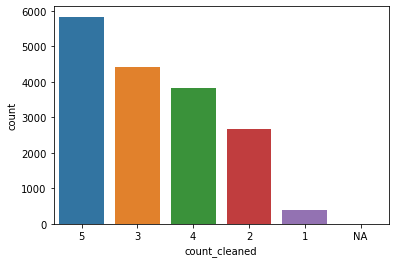

In [68]:
# to prevent the values from affecting the values, max is used 
max_educ = cleaned_person.groupby(['HOUSEID'])["EDUC"].max().reset_index(name="count")

max_educ['count_cleaned'] = max_educ['count'].replace({-7:"NA"})
cat_col_prop(max_educ,'count_cleaned')

#### look at travel questions, ALT16, 23, 45, WRKTRANS, SCHTRN2, SCHTRN1

For travel questions, ALT16, 23, 45, WRKTRANS, SCHTRNS, SCHTRN1 will be dropped as they might cause data leakage, e.g. if student/employee takes a car to and fro work, the household is naturally a vehicle owning household.

     counts  percentage
 0    28166   81.574374
 1      923    2.673193
 2      853    2.470459
 20     751    2.175046
 5      526    1.523401
 4      394    1.141103
 3      380    1.100556
 30     371    1.074490
 10     279    0.808040
 25     239    0.692192
 15     223    0.645853
 6      218    0.631372
 8      163    0.472081
 7      141    0.408364
 22     134    0.388091
 12     121    0.350440
 16      74    0.214319
 18      69    0.199838
 24      65    0.188253
 28      63    0.182461
 26      58    0.167980
 21      56    0.162187
 14      40    0.115848
 17      34    0.098471
-8       30    0.086886
 9       27    0.078197
 19      27    0.078197
 23      26    0.075301
-7       19    0.055028
 27      17    0.049235
 13      15    0.043443
 29      13    0.037651
 11      13    0.037651
     counts  percentage
 0    29727   86.095343
-1     3302    9.563253
 2      386    1.117933
 1      381    1.103452
 3      171    0.495250
 5      131    0.379402
 4      124    0

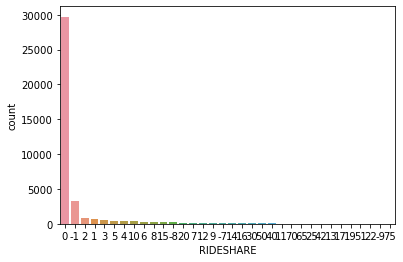

In [69]:
cleaned_person = cleaned_person.drop(columns=['WRKTRANS','SCHTRN2','SCHTRN1','ALT_23','ALT_16','ALT_45'])

# for other trips 
# have to be careful of the negative values 
# walk trip no negative trips

# look at travday 
#cat_col_prop(cleaned_person,'TRAVDAY') # roughly the same, drop

cat_col_prop(cleaned_person,'PTUSED') # roughly the same, drop
cat_col_prop(cleaned_person,'RIDESHARE') # roughly the same, drop

#### Look at the work related questions - NOCONG, TIMETOWK, OCCAT, PUBTIME, WKRMHM, WRKTIME, WKFTPT

In [70]:
# work-related information 
cleaned_person = cleaned_person.drop(columns = ['BIKE4EX','TRAVDAY','R_AGE_IMP','R_SEX_IMP',\
                                                'EDUC', 'NWALKTRP', 'R_AGE', 'R_SEX', 'SCHTYP',\
                                               'PTUSED', 'RIDESHARE'])

cleaned_person.head(3).append(cleaned_person.tail(3))

,HOUSEID,PERSONID,GT1JBLWK,WRK_HOME,WKFTPT,OCCAT,TIMETOWK,NOCONG,PUBTIME,WRKTIME,WKRMHM,FLEXTIME,MEDCOND,MEDCOND6,HEALTH,WORKER,CNTTDTR,GCDWORK,DISTTOWK17,CONDTRAV,CONDRIDE,CONDNIGH,CONDRIVE,CONDPUB,CONDSPEC,CONDTAX,HHSIZE
5,30000012,1,2,2,1,4,30,12,-1,07:30 AM,2,2,2,-1,2,1,9,4.60,6.82,-1,-1,-1,-1,-1,-1,-1,1
16,30000082,1,2,2,1,2,4,3,-1,08:30 AM,1,1,2,-1,2,1,5,1.04,1.65,-1,-1,-1,-1,-1,-1,-1,4
17,30000082,2,2,2,1,4,42,36,-1,08:45 AM,1,2,2,-1,2,1,7,24.35,30.04,-1,-1,-1,-1,-1,-1,-1,4
264175,40794020,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,-1,2,2,6,-9.00,-9.00,-1,-1,-1,-1,-1,-1,-1,2
264176,40794020,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,-1,3,2,5,-9.00,-9.00,-1,-1,-1,-1,-1,-1,-1,2
264217,40794249,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,3,2,2,-9.00,-9.00,1,1,2,2,2,2,2,1


for NOCONG and TIMETOWK, it is the same so choose one, same as DISTTOWK17 and GDWORK

    counts  percentage
-1   18274   52.925162
 1   12523   36.269115
 2    3721   10.776761
-7       8    0.023170
-8       2    0.005792


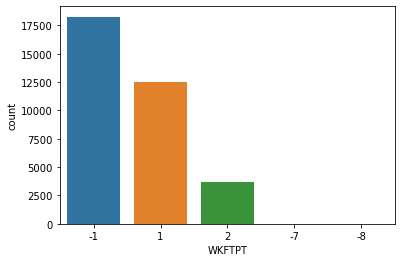

In [71]:
cat_col_prop(cleaned_person,'WKFTPT') 

# check for -1 if they are not workers 
people = cleaned_person[cleaned_person['WKFTPT'] == -1]
# not working -> could mean they are schooling as well 

In [72]:
# get the maximum value of WKFTPT to see the household status
FT_max = cleaned_person.groupby(['HOUSEID','HHSIZE'])["WKFTPT"].max().reset_index(name="count")

non_working = pd.DataFrame(FT_max[FT_max['count'] == -1])

FT = cleaned_person.groupby(['HOUSEID','WKFTPT','HHSIZE'])["WKFTPT"].count().reset_index(name="count")
non_working_HH = non_working['HOUSEID'].tolist()
working = FT[-FT['HOUSEID'].isin(non_working_HH)]
working = working[working['WKFTPT']>0]
working['FT_ratio'] = np.where(working['WKFTPT']==2, 0, working['count']/working['HHSIZE'])
FT_cleaned = working.groupby(['HOUSEID','HHSIZE'])["FT_ratio"].sum().reset_index(name="count")
FT_cleaned

NA = FT_max[FT_max['count'] <-1]
display(NA)
display(non_working)
display(FT_cleaned)

,HOUSEID,HHSIZE,count
2554,30160648,1,-7
4268,30264949,1,-7
6541,30401603,1,-8


,HOUSEID,HHSIZE,count
15,30001011,2,-1
16,30001039,1,-1
17,30001053,3,-1
20,30001349,3,-1
21,30001381,2,-1
...,...,...,...
17160,40792021,2,-1
17173,40793685,2,-1
17175,40793974,1,-1
17176,40794020,2,-1


,HOUSEID,HHSIZE,count
0,30000012,1,1.000000
1,30000082,4,0.500000
2,30000130,2,1.000000
3,30000380,3,0.333333
4,30000434,2,0.500000
...,...,...,...
10622,40792952,5,0.200000
10623,40793204,2,0.000000
10624,40793555,8,0.375000
10625,40793669,4,0.250000


In [73]:
# split the categories up 
OCCAT = cleaned_person.groupby(['HOUSEID','OCCAT','HHSIZE'])["OCCAT"].count().reset_index(name="count")
OCCAT['2_ratio'] = np.where(OCCAT['OCCAT'].isin([2]), OCCAT['count']/OCCAT['HHSIZE'], 0)
OCCAT['1_ratio'] = np.where(OCCAT['OCCAT'].isin([1]), OCCAT['count']/OCCAT['HHSIZE'], 0)
OCCAT['3_ratio'] = np.where(OCCAT['OCCAT'].isin([3]), OCCAT['count']/OCCAT['HHSIZE'], 0)
OCCAT['4_ratio'] = np.where(OCCAT['OCCAT'].isin([4]), OCCAT['count']/OCCAT['HHSIZE'], 0)
OCCAT['97_ratio'] = np.where(OCCAT['OCCAT'].isin([97]), OCCAT['count']/OCCAT['HHSIZE'], 0)
OCCAT['NA_ratio'] = np.where(OCCAT['OCCAT'].isin([-7,-8]), OCCAT['count']/OCCAT['HHSIZE'], 0)
OCCAT['NOTWRK_ratio'] = np.where(OCCAT['OCCAT'].isin([-1,-9]), OCCAT['count']/OCCAT['HHSIZE'], 0)

OCCAT_cleaned = OCCAT.groupby(['HOUSEID','HHSIZE'])['1_ratio','2_ratio','3_ratio','4_ratio','97_ratio','NOTWRK_ratio','NA_ratio'].sum().reset_index()

                  counts  percentage
Professionals       8906   54.819648
Sales               3517   21.648406
Labour-intensive    1950   12.002955
Admin               1853   11.405885
Others                20    0.123107


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

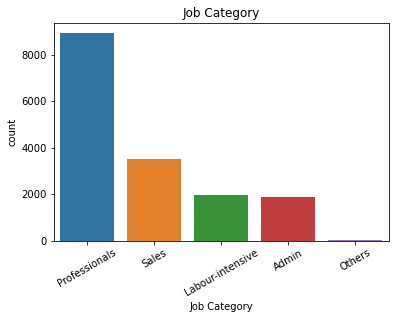

In [74]:
OCCAT_vis = cleaned_person[['HOUSEID','OCCAT','HHSIZE']].copy()
OCCAT_vis = OCCAT_vis[OCCAT_vis['OCCAT']>0]
OCCAT_vis['Job Category'] = OCCAT_vis['OCCAT'].replace({
1:'Sales',
2:'Admin',
3:'Labour-intensive',
4:'Professionals',
97:'Others'})
plt.title('Job Category')
cat_col_prop(OCCAT_vis,'Job Category') 
plt.xticks(rotation=30)

    counts  percentage
4     8906   54.819648
1     3517   21.648406
3     1950   12.002955
2     1853   11.405885
97      20    0.123107


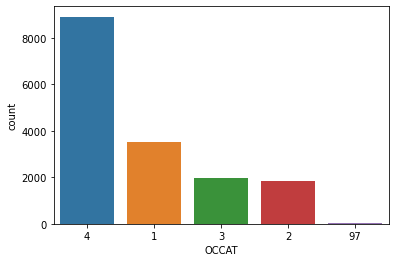

In [75]:
cat_col_prop(OCCAT_vis,'OCCAT')
OCCAT_vis['OCCAT'] = OCCAT_vis['OCCAT'].replace({
1:'Sales',
2:'Admin',
3:'Manufacturing, Farming',
4:'Professionals',
97:'Others'})

     counts  percentage
-1    17584   50.926784
 4     8906   25.793559
 1     3517   10.185936
 3     1950    5.647590
 2     1853    5.366659
-9      690    1.998378
 97      20    0.057924
-8        5    0.014481
-7        3    0.008689


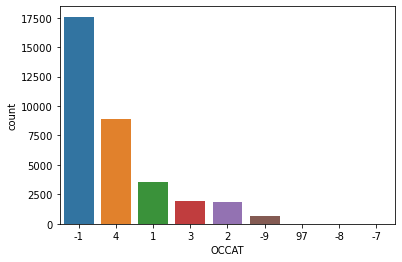

In [76]:
cat_col_prop(cleaned_person,'OCCAT') 

Majority of the households are non-working households. In addition, most of them belong to 4 which is managerial and technical jobs. Hence, this feature will be dropped.

    counts  percentage
5     5836   33.973687
3     4433   25.806264
4     3833   22.313424
2     2679   15.595529
1      389    2.264524
NA       8    0.046571


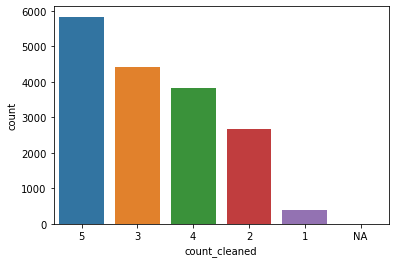

In [77]:
# to prevent the values from affecting the values, max is used 
max_educ['count_cleaned'] = max_educ['count'].replace({-7:"NA"})
cat_col_prop(max_educ,'count_cleaned')

    counts  percentage
 1   16944   49.073216
 2   14280   41.357739
-1    3302    9.563253
-9       2    0.005792


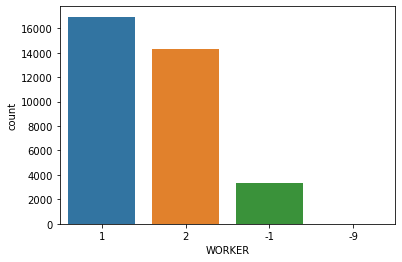

In [78]:
cat_col_prop(cleaned_person,'WORKER') 
# -1 could mean
# not sure what -1 represent
cleaned_person = cleaned_person.drop(columns = ['WORKER'])

     counts  percentage
-1    33276   96.373957
 0      449    1.300394
 10     196    0.567655
 5      131    0.379402
 15     119    0.344648
 20     110    0.318582
 30      47    0.136121
 60      37    0.107159
 3       23    0.066613
 2       22    0.063716
 25      17    0.049235
 7       13    0.037651
 45      12    0.034754
 1       10    0.028962
 40      10    0.028962
-8        9    0.026066
-9        8    0.023170
 4        8    0.023170
 8        7    0.020273
 35       5    0.014481
 6        4    0.011585
 50       4    0.011585
 12       3    0.008689
 14       1    0.002896
 55       1    0.002896
 9        1    0.002896
 24       1    0.002896
-7        1    0.002896
 17       1    0.002896
 32       1    0.002896
 16       1    0.002896


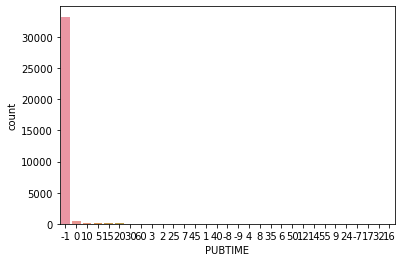

In [79]:
cat_col_prop(cleaned_person,'PUBTIME') 
# high % of -1 in PUBTIME -> dropped

cleaned_person = cleaned_person.drop(columns = ['PUBTIME'])

In [80]:
cleaned_person['TIMETOWK'].value_counts()
# this might mean that they do not need to travel out for work, which can be seen in time to work

time = cleaned_person[['HOUSEID','PERSONID','TIMETOWK']].copy()

In [81]:
positive_time = time[time['TIMETOWK']>=0]
mean_time = positive_time.groupby('HOUSEID')['TIMETOWK'].mean().reset_index()
positive_HH_IDs = mean_time['HOUSEID'].to_list()
negative_time = time[time['TIMETOWK']<0]
negative_time =negative_time[-negative_time['HOUSEID'].isin(positive_HH_IDs)]
mean_time

,HOUSEID,TIMETOWK
0,30000012,30.00
1,30000082,23.00
2,30000130,60.00
3,30000380,10.00
4,30000434,25.00
...,...,...
9757,40792952,20.00
9758,40793204,10.00
9759,40793555,48.75
9760,40793669,4.00


,HOUSEID,TIMETOWK
0,30000496,-1
1,30000817,-1
2,30001011,-1
3,30001039,-1
4,30001053,-1
...,...,...
7411,40792021,-1
7412,40793685,-1
7413,40793974,-1
7414,40794020,-1


,HOUSEID,TIMETOWK


           counts  percentage
15.000000     992   10.161852
20.000000     956    9.793075
10.000000     738    7.559926
30.000000     710    7.273100
25.000000     614    6.289695
...           ...         ...
3.333333        1    0.010244
37.666667       1    0.010244
23.666667       1    0.010244
26.250000       1    0.010244
13.666667       1    0.010244

[291 rows x 2 columns]


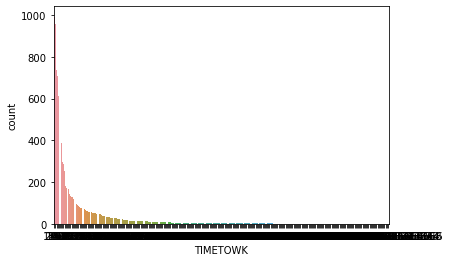

In [82]:
negative_check = negative_time.groupby('HOUSEID')['TIMETOWK'].min().reset_index()
display(negative_check[negative_check['TIMETOWK'] == -1]) # put them as NOT WRK
display(negative_check[negative_check['TIMETOWK'] == -9]) # put them as NA-7,-8
cat_col_prop(mean_time,'TIMETOWK') 

         counts  percentage
10 - 20    3164   32.411391
>30        2615   26.787544
20 - 30    2000   20.487605
<=10       1983   20.313460


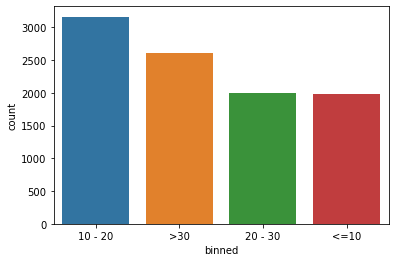

In [83]:
bins = [0, 10, 20, 30, 3000]
bins_label = ['<=10','10 - 20','20 - 30','>30']
mean_time['binned'] = pd.cut(mean_time['TIMETOWK'], bins, labels = bins_label,include_lowest=True)

cat_col_prop(mean_time,'binned')

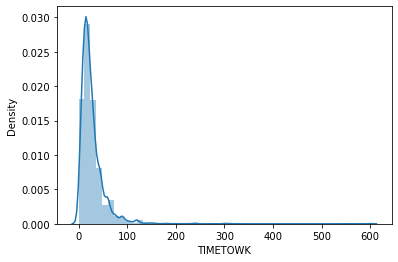

In [84]:
sns.distplot(mean_time['TIMETOWK'])

In [85]:
cleaned_person[cleaned_person['WRKTIME']=='-7']

,HOUSEID,PERSONID,GT1JBLWK,WRK_HOME,WKFTPT,OCCAT,TIMETOWK,NOCONG,WRKTIME,WKRMHM,FLEXTIME,MEDCOND,MEDCOND6,HEALTH,CNTTDTR,GCDWORK,DISTTOWK17,CONDTRAV,CONDRIDE,CONDNIGH,CONDRIVE,CONDPUB,CONDSPEC,CONDTAX,HHSIZE
6332,30025610,2,2,1,1,4,-1,-1,-7,-1,1,2,-1,3,0,-9.00,-9.00,-1,-1,-1,-1,-1,-1,-1,2
17773,30070435,1,2,2,-7,1,0,-1,-7,-7,-7,2,-1,4,6,8.30,12.03,-1,-1,-1,-1,-1,-1,-1,4
19720,30078137,1,2,1,2,4,-1,-1,-7,-1,-7,2,-1,3,2,-9.00,-9.00,-1,-1,-1,-1,-1,-1,-1,2
22405,30088919,1,2,2,1,4,12,10,-7,2,2,2,-1,2,5,3.97,6.62,-1,-1,-1,-1,-1,-1,-1,1
22813,30090538,1,1,2,1,4,1,-1,-7,1,1,2,-1,2,5,3.20,4.31,-1,-1,-1,-1,-1,-1,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250796,40707442,1,2,1,2,4,-1,-1,-7,-1,1,2,-1,1,3,-9.00,-9.00,1,2,2,2,2,2,2,2
251763,40713153,1,1,1,-7,4,-1,-1,-7,-1,1,2,-1,3,2,-9.00,-9.00,-1,-1,-1,-1,-1,-1,-1,4
254066,40727377,2,2,1,1,4,-1,-1,-7,-1,1,2,-1,2,1,-9.00,-9.00,-1,-1,-1,-1,-1,-1,-1,2
254570,40730607,2,2,1,1,2,-1,-1,-7,-1,1,2,-1,1,2,-9.00,-9.00,-1,-1,-1,-1,-1,-1,-1,2


In [86]:
start_time = cleaned_person[['HOUSEID','PERSONID','WRKTIME']].copy()
start_time['WRKTIME_AMPM'] = start_time['WRKTIME'].apply(lambda x: (str(x[-2:])))
start_time['WRKTIME_HOUR'] = start_time['WRKTIME'].apply(lambda x: int(str(x[:2])))
start_time['WRKTIME_HOUR_cleaned'] = np.where(start_time['WRKTIME_AMPM'] == 'PM',start_time['WRKTIME_HOUR'] + 12, start_time['WRKTIME_HOUR'])
start_time['WRKTIME_HOUR_cleaned'] = np.where(start_time['WRKTIME_HOUR'] == 12,start_time['WRKTIME_HOUR'], start_time['WRKTIME_HOUR_cleaned'])
start_time[start_time['WRKTIME_AMPM'] == 'PM']

,HOUSEID,PERSONID,WRKTIME,WRKTIME_AMPM,WRKTIME_HOUR,WRKTIME_HOUR_cleaned
78,30000380,2,06:00 PM,PM,6,18
94,30000439,4,04:00 PM,PM,4,16
641,30002883,3,12:00 PM,PM,12,12
659,30002989,2,01:00 PM,PM,1,13
776,30003489,1,02:50 PM,PM,2,14
...,...,...,...,...,...,...
263464,40789044,5,05:00 PM,PM,5,17
263537,40789513,2,04:00 PM,PM,4,16
263771,40791091,2,05:45 PM,PM,5,17
264028,40792952,4,05:00 PM,PM,5,17


In [87]:
# 17584 corresponds to OCCAT
# None from -7,-8

earliest_time = start_time.groupby(['HOUSEID','WRKTIME_HOUR_cleaned']).count().reset_index()
earliest_time

,HOUSEID,WRKTIME_HOUR_cleaned,PERSONID,WRKTIME,WRKTIME_AMPM,WRKTIME_HOUR
0,30000012,7,1,1,1,1
1,30000082,8,2,2,2,2
2,30000130,9,2,2,2,2
3,30000380,-1,2,2,2,2
4,30000380,18,1,1,1,1
...,...,...,...,...,...,...
26899,40793808,7,1,1,1,1
26900,40793808,9,1,1,1,1
26901,40793974,-1,1,1,1,1
26902,40794020,-1,2,2,2,2


In [88]:
time_plus = earliest_time[earliest_time['WRKTIME_HOUR_cleaned']>=0]
early_start = time_plus.groupby(['HOUSEID'])['WRKTIME_HOUR_cleaned'].min().reset_index()
early_start_ids = early_start['HOUSEID'].to_list()
early_start

,HOUSEID,WRKTIME_HOUR_cleaned
0,30000012,7
1,30000082,8
2,30000130,9
3,30000380,18
4,30000434,8
...,...,...
10479,40792952,8
10480,40793204,14
10481,40793555,6
10482,40793669,8


In [89]:
negative_sttime = earliest_time[earliest_time['WRKTIME_HOUR_cleaned'] < 0]
negative_sttime = negative_sttime[-negative_sttime['HOUSEID'].isin(early_start_ids)]
negative_sttime

,HOUSEID,WRKTIME_HOUR_cleaned,PERSONID,WRKTIME,WRKTIME_AMPM,WRKTIME_HOUR
25,30001011,-1,2,2,2,2
26,30001039,-1,1,1,1,1
27,30001053,-1,2,2,2,2
33,30001349,-9,1,1,1,1
34,30001349,-1,2,2,2,2
...,...,...,...,...,...,...
26866,40792021,-1,2,2,2,2
26897,40793685,-1,2,2,2,2
26901,40793974,-1,1,1,1,1
26902,40794020,-1,2,2,2,2


In [90]:
negative_sttime = negative_sttime.groupby(['HOUSEID'])['WRKTIME_HOUR_cleaned'].min().reset_index()
display(negative_sttime[negative_sttime['WRKTIME_HOUR_cleaned'] == -1])
display(negative_sttime[negative_sttime['WRKTIME_HOUR_cleaned'] == -9]) # -7,-8,-9
early_start

,HOUSEID,WRKTIME_HOUR_cleaned
0,30001011,-1
1,30001039,-1
2,30001053,-1
4,30001381,-1
5,30001456,-1
...,...,...
6689,40792021,-1
6690,40793685,-1
6691,40793974,-1
6692,40794020,-1


,HOUSEID,WRKTIME_HOUR_cleaned
3,30001349,-9
42,30008251,-9
68,30012338,-9
74,30013015,-9
77,30013369,-9
...,...,...
6383,40718101,-9
6538,40756807,-9
6549,40758953,-9
6552,40759946,-9


,HOUSEID,WRKTIME_HOUR_cleaned
0,30000012,7
1,30000082,8
2,30000130,9
3,30000380,18
4,30000434,8
...,...,...
10479,40792952,8
10480,40793204,14
10481,40793555,6
10482,40793669,8


    counts  percentage
-1   20090   58.184662
 2   11934   34.563253
 1    2486    7.199954
-7      11    0.031858
-8       7    0.020273


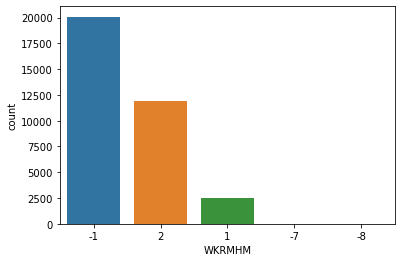

In [91]:
cat_col_prop(cleaned_person,'WKRMHM') 

In [92]:
flex = cleaned_person[['HOUSEID','PERSONID','WRK_HOME','HHSIZE']].copy()
flex_grouped = flex.groupby(['HOUSEID','WRK_HOME','HHSIZE']).count().reset_index()

flex_grouped

,HOUSEID,WRK_HOME,HHSIZE,PERSONID
0,30000012,2,1,1
1,30000082,2,4,2
2,30000130,2,2,2
3,30000380,-1,3,2
4,30000380,2,3,1
...,...,...,...,...
23534,40793808,1,3,1
23535,40793808,2,3,1
23536,40793974,-1,1,1
23537,40794020,-1,2,2


Upon analyzing the work time start of the respondents, majority of them start their work in the morning, which is a typical thing. Hence, this feature will not be considered.

In [93]:
flex_plus_max = flex_grouped[flex_grouped['WRK_HOME']>0]
flex_plus_max['yes_wfh'] = np.where(flex_plus_max['WRK_HOME'] == 2,0, flex_plus_max['PERSONID']/flex_plus_max['HHSIZE'] )

flex_plus_max

,HOUSEID,WRK_HOME,HHSIZE,PERSONID,yes_wfh
0,30000012,2,1,1,0.000000
1,30000082,2,4,2,0.000000
2,30000130,2,2,2,0.000000
4,30000380,2,3,1,0.000000
5,30000434,1,2,1,0.500000
...,...,...,...,...,...
23527,40793204,2,2,1,0.000000
23529,40793555,2,8,4,0.000000
23531,40793669,2,4,2,0.000000
23534,40793808,1,3,1,0.333333


In [94]:
flex_HH = flex_plus_max.groupby(['HOUSEID'])["yes_wfh"].sum().reset_index(name="count") 
flex_negative = flex_grouped[flex_grouped['WRK_HOME']<0]
flex_HH_ID = flex_HH['HOUSEID'].to_list()

flex_negative = flex_negative[-flex_negative['HOUSEID'].isin(flex_HH_ID)]
flex_min = flex_negative.groupby(['HOUSEID'])["WRK_HOME"].max().reset_index(name="count") 

flex_min

,HOUSEID,count
0,30001011,-1
1,30001039,-1
2,30001053,-1
3,30001349,-1
4,30001381,-1
...,...,...
6542,40792021,-1
6543,40793685,-1
6544,40793974,-1
6545,40794020,-1


In [95]:
#cat_col_prop(cleaned_person,'DISTTOWK17')
dist = cleaned_person[['HOUSEID','PERSONID','DISTTOWK17']].copy()
dist_plus = dist[dist['DISTTOWK17']>=0]
average_dist = dist_plus.groupby(['HOUSEID'])['DISTTOWK17'].mean().reset_index(name="count") 
average_dist_IDs = average_dist['HOUSEID'].tolist()

In [96]:
dist_minus = dist[dist['DISTTOWK17']<0]
dist_minus = dist_minus[-dist_minus['HOUSEID'].isin(average_dist_IDs)]
dist_minus = dist_minus.groupby(['HOUSEID'])['DISTTOWK17'].min().reset_index(name="count") 

dist_minus

,HOUSEID,count
0,30000496,-9.0
1,30000817,-9.0
2,30001011,-9.0
3,30001039,-9.0
4,30001053,-9.0
...,...,...
7401,40792021,-9.0
7402,40793685,-9.0
7403,40793974,-9.0
7404,40794020,-9.0


               counts  percentage
>15 miles        3174   32.480557
<=5 miles        2833   28.990995
5-10 miles       2228   22.799836
10 - 15 miles    1537   15.728612


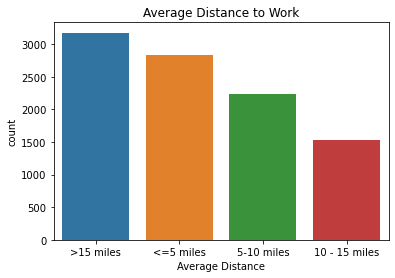

In [97]:
dist_bins = [0, 5, 10, 15, 3000]
dist_bins_label = ['<=5 miles','5-10 miles','10 - 15 miles','>15 miles']
average_dist['Average Distance'] = pd.cut(average_dist['count'], dist_bins, labels = dist_bins_label,include_lowest=True)
plt.title('Average Distance to Work')
cat_col_prop(average_dist,'Average Distance')

In [98]:
cleaned_person = cleaned_person.drop(columns = ['NOCONG','GCDWORK','WKRMHM'])

#### Treatment of all selected metrics

           counts  percentage
65.000000     330    1.921062
64.000000     308    1.792991
67.000000     305    1.775527
66.000000     305    1.775527
68.000000     292    1.699849
...           ...         ...
13.333333       1    0.005821
17.800000       1    0.005821
55.750000       1    0.005821
15.428571       1    0.005821
34.166667       1    0.005821

[518 rows x 2 columns]


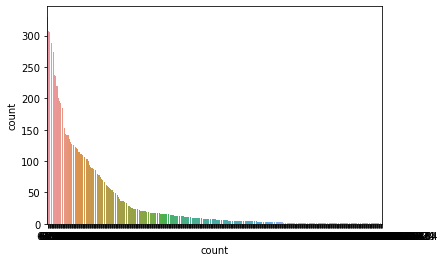

In [99]:
# mean age
cat_col_prop(mean_age,'count')

         counts  percentage
>60        7738   45.045989
50 - 60    2885   16.794737
30 - 40    2426   14.122715
<=30       2306   13.424147
40 - 50    1823   10.612411


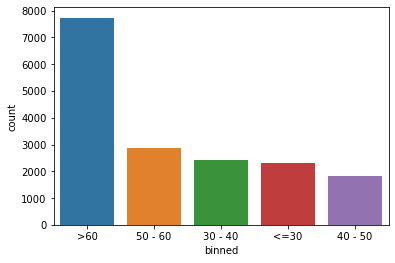

In [100]:
bins = [0, 30, 40, 50, 60, 100]
bins_label = ['<=30','30 - 40','40 - 50','50 - 60','>60']
mean_age['binned'] = pd.cut(mean_age['count'], bins, labels = bins_label,include_lowest=True)

cat_col_prop(mean_age,'binned')

In [101]:
mean_age

,HOUSEID,count,binned
0,30000012,45.000000,40 - 50
1,30000082,38.500000,30 - 40
2,30000130,45.000000,40 - 50
3,30000380,37.333333,30 - 40
4,30000434,67.500000,>60
...,...,...,...
17173,40793685,67.500000,>60
17174,40793808,42.000000,40 - 50
17175,40793974,81.000000,>60
17176,40794020,72.500000,>60


      counts  percentage
1       3514   33.066717
0.5     2629   24.738873
<0.5    2032   19.121107
0       1682   15.827609
>0.5     770    7.245695


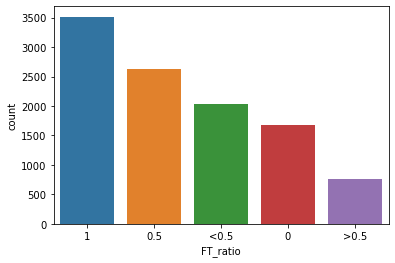

In [102]:
FT_cleaned['FT_ratio'] = 'NA'
FT_cleaned.loc[FT_cleaned['count']==0,'FT_ratio']= '0'
FT_cleaned.loc[FT_cleaned['count']==0.5,'FT_ratio']= '0.5'
FT_cleaned.loc[FT_cleaned['count'].between(0,0.5,inclusive = False),'FT_ratio'] = '<0.5'
FT_cleaned.loc[FT_cleaned['count'].between(0.5,1, inclusive = False),'FT_ratio'] = '>0.5'
FT_cleaned.loc[FT_cleaned['count']==1,'FT_ratio'] ='1'

cat_col_prop(FT_cleaned,'FT_ratio')

In [103]:
NA['FT_ratio'] = 'NA'
non_working['FT_ratio'] = 'non-work'

FT_cleaned_im = FT_cleaned[["HOUSEID",'FT_ratio']]
NA_im = NA[['HOUSEID','FT_ratio']]
non_working_im = non_working[['HOUSEID','FT_ratio']]

In [104]:
average_dist

,HOUSEID,count,Average Distance
0,30000012,6.820000,5-10 miles
1,30000082,15.845000,>15 miles
2,30000130,17.410000,>15 miles
3,30000380,1.190000,<=5 miles
4,30000434,15.440000,>15 miles
...,...,...,...
9767,40792952,27.436667,>15 miles
9768,40793204,5.390000,5-10 miles
9769,40793555,21.002500,>15 miles
9770,40793669,2.405000,<=5 miles


In [105]:
average_dist_im = average_dist[['HOUSEID','Average Distance']].copy() #'binned'
average_dist_im

,HOUSEID,Average Distance
0,30000012,5-10 miles
1,30000082,>15 miles
2,30000130,>15 miles
3,30000380,<=5 miles
4,30000434,>15 miles
...,...,...
9767,40792952,>15 miles
9768,40793204,5-10 miles
9769,40793555,>15 miles
9770,40793669,<=5 miles


In [106]:
dist_minus['binned'] = 'Not Sure'
dist_minus_im = dist_minus[['HOUSEID','binned']].copy()

In [107]:
negative_check['binned'] = negative_check['TIMETOWK'].apply(lambda x: 'NA' if x < -1 else 'non-work')
negative_check_im = negative_check[['HOUSEID','binned']].copy()

In [108]:
mean_time_im = mean_time[['HOUSEID','binned']].copy()
mean_time_im

,HOUSEID,binned
0,30000012,20 - 30
1,30000082,20 - 30
2,30000130,>30
3,30000380,<=10
4,30000434,20 - 30
...,...,...
9757,40792952,10 - 20
9758,40793204,<=10
9759,40793555,>30
9760,40793669,<=10


In [109]:
# consolidation of features
mean_age_final = mean_age[['HOUSEID','count','binned']].copy()
mean_age_final = mean_age_final.rename(columns={'count':'AVG_AGE','binned':'AVG_AGE_binned'})

# max EDUC
max_educ_final = max_educ[['HOUSEID','count_cleaned']].copy()
max_educ_final = max_educ_final.rename(columns={'count_cleaned':'HIGH_EDUC'})

# Full Time/Part Time
FT_final = pd.concat([FT_cleaned_im, NA_im, non_working_im])

# average_work_dist
average_dist_final = average_dist_im #pd.concat([average_dist_im,dist_minus_im])
average_dist_final = average_dist_final.rename(columns={'Average Distance':'AVG_WORK_DIST'})

# Time to work
time_final = pd.concat([negative_check_im,mean_time_im])
time_final = time_final.rename(columns ={'binned':'AVG_TIME'})

In [110]:
average_dist_final.head(3).append(average_dist_final.tail(3))

,HOUSEID,AVG_WORK_DIST
0,30000012,5-10 miles
1,30000082,>15 miles
2,30000130,>15 miles
9769,40793555,>15 miles
9770,40793669,<=5 miles
9771,40793808,<=5 miles


In [111]:
average_dist_im.head(3).append(average_dist_im.tail(3))

,HOUSEID,Average Distance
0,30000012,5-10 miles
1,30000082,>15 miles
2,30000130,>15 miles
9769,40793555,>15 miles
9770,40793669,<=5 miles
9771,40793808,<=5 miles


In [112]:
dist_minus_im.head(3).append(dist_minus_im.tail(3))

,HOUSEID,binned
0,30000496,Not Sure
1,30000817,Not Sure
2,30001011,Not Sure
7403,40793974,Not Sure
7404,40794020,Not Sure
7405,40794249,Not Sure


In [113]:
dist_minus_im['binned'].value_counts()

Not Sure    7406
Name: binned, dtype: int64

In [114]:
dist_minus.head(3)

,HOUSEID,count,binned
0,30000496,-9.0,Not Sure
1,30000817,-9.0,Not Sure
2,30001011,-9.0,Not Sure


In [115]:
full_df = mean_age_final.merge(max_educ_final, on = 'HOUSEID', how = 'left')
full_df = full_df.merge(FT_final, on = 'HOUSEID', how = 'left')
full_df = full_df.merge(average_dist_final, on = 'HOUSEID', how = 'left')
full_df = full_df.merge(time_final, on = 'HOUSEID', how = 'left')

full_df.head(3).append(full_df.tail(3))

,HOUSEID,AVG_AGE,AVG_AGE_binned,HIGH_EDUC,FT_ratio,AVG_WORK_DIST,AVG_TIME
0,30000012,45.0,40 - 50,5,1,5-10 miles,20 - 30
1,30000082,38.5,30 - 40,5,0.5,>15 miles,20 - 30
2,30000130,45.0,40 - 50,5,1,>15 miles,>30
17175,40793974,81.0,>60,2,non-work,NaN,non-work
17176,40794020,72.5,>60,3,non-work,NaN,non-work
17177,40794249,80.0,>60,2,non-work,NaN,non-work


In [116]:
columns = ['HOUSEID', 'CNTTDTR']
average_trip = cleaned_person[columns].groupby('HOUSEID')['CNTTDTR'].mean().reset_index()
average_trip.head(3)

,HOUSEID,CNTTDTR
0,30000012,9.0
1,30000082,6.0
2,30000130,2.0


       counts  percentage
<=2      5732   33.368262
>5       3670   21.364536
2 - 3    2928   17.045058
3 - 4    2775   16.154384
4 - 5    2073   12.067761


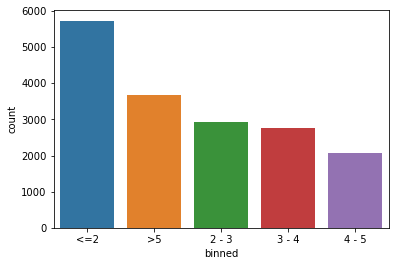

In [117]:
bins = [0, 2, 3, 4, 5, 30]
bins_label = ['<=2','2 - 3','3 - 4','4 - 5','>5']
average_trip['binned'] = pd.cut(average_trip['CNTTDTR'], bins, labels = bins_label,include_lowest=True)
average_trip
cat_col_prop(average_trip, 'binned')

In [118]:
#FLEXTIME, add new catogorical variables 
cleaned_person['FLEXTIME'].value_counts()

-1    17584
 2     8968
 1     7248
-9      690
-7       22
-8       16
Name: FLEXTIME, dtype: int64

In [119]:
flex_time = cleaned_person[['HOUSEID','HHSIZE','FLEXTIME']].copy()
flex_positive = flex_time[flex_time['FLEXTIME']>0]
flex_negative = flex_time[flex_time['FLEXTIME']<0]

          counts  percentage
0.000000    3928   37.004239
0.500000    2278   21.460198
1.000000    2053   19.340556
0.333333     816    7.687235
0.250000     553    5.209609
0.666667     449    4.229863
0.200000     174    1.639190
0.400000     107    1.008008
0.750000     101    0.951484
0.166667      47    0.442770
0.600000      44    0.414508
0.142857      22    0.207254
0.800000       8    0.075365
0.428571       7    0.065944
0.125000       7    0.065944
0.285714       7    0.065944
0.100000       3    0.028262
0.111111       3    0.028262
0.222222       3    0.028262
0.625000       2    0.018841
0.375000       1    0.009421
0.300000       1    0.009421
0.833333       1    0.009421


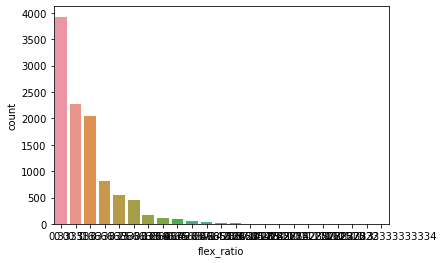

In [120]:
flex_positive = flex_positive.groupby(['HOUSEID','HHSIZE','FLEXTIME'])["FLEXTIME"].count().reset_index(name="count")
flex_positive

flex_positive['flex_ratio'] = np.where(flex_positive['FLEXTIME']==1, 0, flex_positive['count']/flex_positive['HHSIZE'])
flex_cleaned = flex_positive.groupby(['HOUSEID'])['flex_ratio'].sum().reset_index()
flex_cleaned
flex_cleaned_HH = flex_cleaned['HOUSEID'].tolist()

cat_col_prop(flex_cleaned, 'flex_ratio')

In [121]:
flex_cleaned['binned'] = 'NA'
flex_cleaned.loc[flex_cleaned['flex_ratio']==0,'binned'] ='0'
flex_cleaned.loc[flex_cleaned['flex_ratio'].between(0,0.5,inclusive = False),'binned'] = '<0.5'
flex_cleaned.loc[flex_cleaned['flex_ratio'].between(0.5,1, inclusive = False),'binned'] = '>0.5'
flex_cleaned.loc[flex_cleaned['flex_ratio']==1,'binned'] ='1'
flex_cleaned.loc[flex_cleaned['flex_ratio']==0.5,'binned'] ='0.5'
flex_cleaned
flex_cleaned_im = flex_cleaned[['HOUSEID','binned']]

In [122]:
flex_negative 
flex_negative = flex_negative[~flex_negative['HOUSEID'].isin(flex_cleaned_HH)]
flex_negative_agg = flex_negative.groupby(['HOUSEID'])['FLEXTIME'].max().reset_index()
flex_negative_agg
flex_negative_agg['binned'] = np.where(flex_negative_agg['FLEXTIME'].isin([-1,-9]), 'non-work', 'NA')
flex_negative_agg_im = flex_negative_agg[['HOUSEID','binned']]
flex_negative_agg_im

flex_final = pd.concat([flex_negative_agg_im,flex_cleaned_im])
flex_final.head(3)

,HOUSEID,binned
0,30001011,non-work
1,30001039,non-work
2,30001053,non-work


In [123]:
#GT1JBLWK, More than One Job
cleaned_person['GT1JBLWK'].value_counts()

-1    17584
 2    14502
 1     1752
-9      690
Name: GT1JBLWK, dtype: int64

          counts  percentage
1.000000    4162   39.138612
0.500000    2967   27.901072
0.333333     807    7.588866
0.666667     783    7.363175
0.000000     731    6.874177
0.250000     488    4.589054
0.400000     186    1.749107
0.200000     167    1.570434
0.750000     145    1.363551
0.600000      60    0.564228
0.166667      56    0.526613
0.800000      20    0.188076
0.142857      14    0.131653
0.285714      14    0.131653
0.125000       8    0.075230
0.428571       6    0.056423
0.111111       5    0.047019
0.571429       3    0.028211
0.375000       2    0.018808
0.625000       2    0.018808
0.300000       2    0.018808
0.833333       2    0.018808
0.222222       2    0.018808
0.100000       1    0.009404
0.714286       1    0.009404


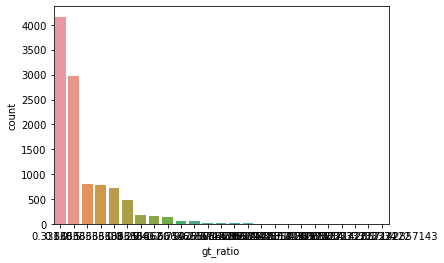

In [124]:
gtjob = cleaned_person[['HOUSEID','HHSIZE','GT1JBLWK']].copy()
gtjob_positive = gtjob[gtjob['GT1JBLWK'] > 0]
gtjob_cleaned = gtjob_positive.groupby(['HOUSEID','HHSIZE','GT1JBLWK'])["GT1JBLWK"].count().reset_index(name="count")
gtjob_cleaned['gt_ratio'] = np.where(gtjob_cleaned['GT1JBLWK']==1, 0, gtjob_cleaned['count']/gtjob_cleaned['HHSIZE'])
gt_cleaned = gtjob_cleaned.groupby(['HOUSEID'])['gt_ratio'].sum().reset_index()
gt_cleaned_HH = gt_cleaned['HOUSEID'].tolist()
gt_cleaned

# checking and binning 
cat_col_prop(gt_cleaned, 'gt_ratio')

      counts  percentage
1       4162   39.138612
0.5     2967   27.901072
<0.5    1758   16.531879
>0.5    1016    9.554260
0        731    6.874177


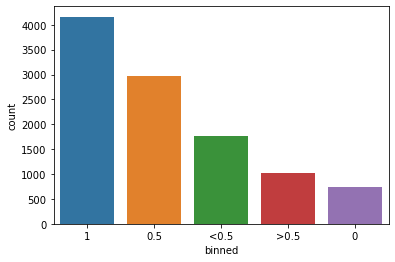

In [125]:
gt_cleaned['binned'] = 'NA'
gt_cleaned.loc[gt_cleaned['gt_ratio']==0,'binned'] ='0'
gt_cleaned.loc[gt_cleaned['gt_ratio'].between(0,0.5,inclusive = False),'binned'] = '<0.5'
gt_cleaned.loc[gt_cleaned['gt_ratio'].between(0.5,1, inclusive = False),'binned'] = '>0.5'
gt_cleaned.loc[gt_cleaned['gt_ratio']==1,'binned'] ='1'
gt_cleaned.loc[gt_cleaned['gt_ratio']==0.5,'binned'] ='0.5'

cat_col_prop(gt_cleaned, 'binned')
gt_cleaned_im = gt_cleaned[['HOUSEID','binned']]

In [126]:
gt_negative = gtjob[gtjob['GT1JBLWK'] <0]
gt_negative = gt_negative[~gt_negative['HOUSEID'].isin(gt_cleaned_HH)]
gt_negative_cleaned = gt_negative.groupby(['HOUSEID'])["GT1JBLWK"].min().reset_index(name="count")
gt_negative_cleaned['binned'] = 'non-work'
gt_negative_cleaned_im = gt_negative_cleaned[['HOUSEID','binned']]

In [127]:
#choose the worst health condition from same household
columns = ['HOUSEID', 'PERSONID', 'HEALTH']
worst_health = cleaned_person[columns].groupby('HOUSEID')['HEALTH'].max().reset_index()
worst_health['HEALTH'] = worst_health['HEALTH'].apply(lambda x: 'NA' if x < 0 else x)
worst_health.head(3)

,HOUSEID,HEALTH
0,30000012,2
1,30000082,2
2,30000130,3


    counts  percentage
2     6031   35.108860
3     5468   31.831412
1     2828   16.462918
4     2229   12.975899
5      612    3.562696
NA      10    0.058214


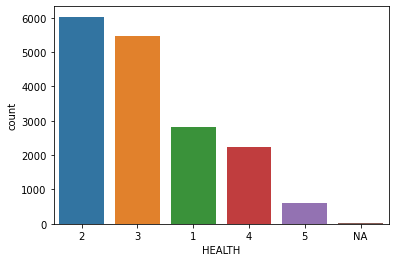

In [128]:
cat_col_prop(worst_health, 'HEALTH')

In [129]:
## compilation of metrics
average_trip_final = average_trip.rename(columns={'CNTTDTR':'avg_trips','binned':'avg_trips_binned'})

## more than 1 job ratio
gt_final = pd.concat([gt_negative_cleaned_im,gt_cleaned_im])
gt_final = gt_final.rename(columns={'binned':'one_job'})
gt_final.head(3)

## flexible time
flex_final = flex_final.rename(columns={'binned':'flexible_work'})
flex_final.head(3)

,HOUSEID,flexible_work
0,30001011,non-work
1,30001039,non-work
2,30001053,non-work


In [130]:
full_df2 = worst_health.merge(average_trip_final, on = 'HOUSEID', how = 'left')
full_df2 = full_df2.merge(gt_final, on = 'HOUSEID', how = 'left')
full_df2 = full_df2.merge(flex_final, on = 'HOUSEID', how = 'left')
full_df2.head(3).append(full_df2.tail(3))

,HOUSEID,HEALTH,avg_trips,avg_trips_binned,one_job,flexible_work
0,30000012,2,9.0,>5,1,1
1,30000082,2,6.0,>5,0.5,<0.5
2,30000130,3,2.0,<=2,1,1
17175,40793974,2,7.0,>5,non-work,non-work
17176,40794020,3,5.5,>5,non-work,non-work
17177,40794249,3,2.0,<=2,non-work,non-work


In [131]:
household_df = cleaned_ny.merge(full_df, on = 'HOUSEID', how = 'left')
household_final = household_df.merge(full_df2, on = 'HOUSEID', how = 'left')

          counts  percentage
1.000000    3514   33.066717
0.500000    2629   24.738873
0.000000    1682   15.827609
0.333333     899    8.459584
0.666667     666    6.267056
0.250000     618    5.815376
0.200000     215    2.023149
0.400000     172    1.618519
0.166667      71    0.668110
0.750000      70    0.658700
0.600000      23    0.216430
0.142857      22    0.207020
0.285714      12    0.112920
0.125000      11    0.103510
0.800000       9    0.084690
0.428571       5    0.047050
0.100000       2    0.018820
0.375000       2    0.018820
0.111111       2    0.018820
0.571429       1    0.009410
0.714286       1    0.009410
0.222222       1    0.009410


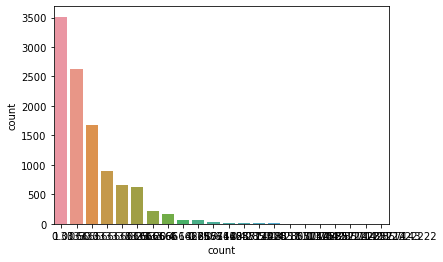

In [132]:
# WKFTPT
cat_col_prop(FT_cleaned,'count')

          counts  percentage
0.000000   14131   82.262196
0.500000    1110    6.461753
1.000000     657    3.824659
0.333333     524    3.050413
0.250000     375    2.183025
0.200000     136    0.791710
0.666667     102    0.593783
0.166667      47    0.273606
0.400000      37    0.215392
0.750000      16    0.093142
0.142857      14    0.081500
0.600000      13    0.075678
0.125000       6    0.034928
0.100000       4    0.023286
0.428571       2    0.011643
0.800000       2    0.011643
0.222222       1    0.005821
0.111111       1    0.005821


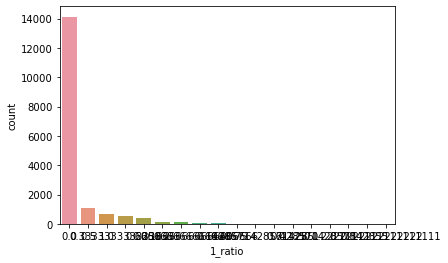

In [133]:
cat_col_prop(OCCAT_cleaned,'1_ratio')
#OCCAT_cleaned 
#not useful as 0 forms the majority of all the respective job categories

    counts  percentage
7     2871   27.384586
8     2849   27.174742
9     1432   13.658909
6     1403   13.382297
5      456    4.349485
10     418    3.987028
11     136    1.297215
14     128    1.220908
4      117    1.115986
15     109    1.039680
12     104    0.991988
13      86    0.820298
16      83    0.791683
17      64    0.610454
3       48    0.457841
18      39    0.371995
22      35    0.333842
23      29    0.276612
21      21    0.200305
19      18    0.171690
2       17    0.162152
20      11    0.104922
1        9    0.085845
0        1    0.009538


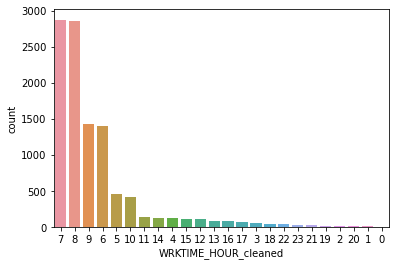

In [134]:
cat_col_prop(early_start,'WRKTIME_HOUR_cleaned')

In [135]:
early_start['work_start'] = 'NA'
early_start.loc[early_start['WRKTIME_HOUR_cleaned'].between(0,4,inclusive = True),'work_start'] = 'wee hours'
early_start.loc[early_start['WRKTIME_HOUR_cleaned'].between(5,9, inclusive = True),'work_start'] = 'morning'
early_start.loc[early_start['WRKTIME_HOUR_cleaned'].between(10,12, inclusive = True),'work_start'] = 'lunch'
early_start.loc[early_start['WRKTIME_HOUR_cleaned'].between(12,15, inclusive = True),'work_start'] = 'early afternoon'
early_start.loc[early_start['WRKTIME_HOUR_cleaned'].between(16,18, inclusive = True),'work_start'] = 'late afternoon'
early_start.loc[early_start['WRKTIME_HOUR_cleaned'].between(18,23, inclusive = True),'work_start'] = 'night'

                 counts  percentage
morning            9011   85.950019
lunch               554    5.284243
early afternoon     427    4.072873
wee hours           192    1.831362
night               153    1.459367
late afternoon      147    1.402137


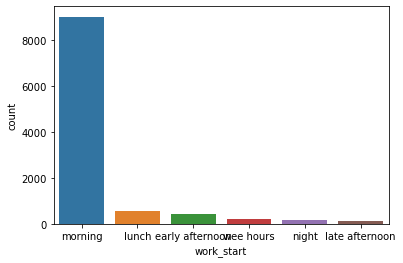

In [136]:
cat_col_prop(early_start,'work_start')

In [137]:
negative_sttime['binned'] = negative_sttime['WRKTIME_HOUR_cleaned'].apply(lambda x: 'NA' if x < -1 else 'non-work')
negative_sttime

,HOUSEID,WRKTIME_HOUR_cleaned,binned
0,30001011,-1,non-work
1,30001039,-1,non-work
2,30001053,-1,non-work
3,30001349,-9,NA
4,30001381,-1,non-work
...,...,...,...
6689,40792021,-1,non-work
6690,40793685,-1,non-work
6691,40793974,-1,non-work
6692,40794020,-1,non-work


          counts  percentage
0.000000    8988   84.545198
0.500000     714    6.716207
1.000000     376    3.536826
0.333333     230    2.163484
0.250000     200    1.881291
0.200000      54    0.507948
0.666667      36    0.338632
0.166667      13    0.122284
0.400000       7    0.065845
0.142857       6    0.056439
0.125000       3    0.028219
0.750000       2    0.018813
0.600000       1    0.009406
0.285714       1    0.009406


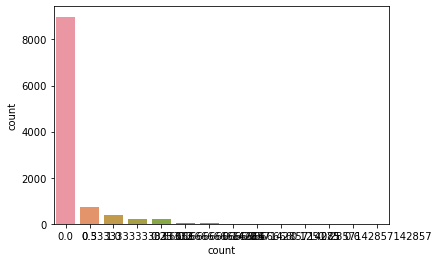

In [138]:
cat_col_prop(flex_HH,'count') # big skew

In [139]:
flex_HH['flex_ratio'] = 'NA'
flex_HH.loc[flex_HH['count']==0,'flex_ratio']= '0'
flex_HH.loc[flex_HH['count']>0,'flex_ratio']= '>0'

    counts  percentage
0     8988   84.545198
>0    1643   15.454802


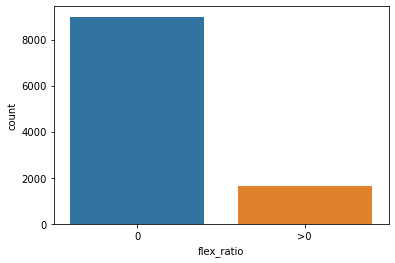

In [140]:
cat_col_prop(flex_HH,'flex_ratio')

In [141]:
flex_min['binned'] = flex_min['count'].apply(lambda x: 'NA' if x < -1 else 'non-work')
flex_min

,HOUSEID,count,binned
0,30001011,-1,non-work
1,30001039,-1,non-work
2,30001053,-1,non-work
3,30001349,-1,non-work
4,30001381,-1,non-work
...,...,...,...
6542,40792021,-1,non-work
6543,40793685,-1,non-work
6544,40793974,-1,non-work
6545,40794020,-1,non-work


In [142]:
dist_final = pd.concat([average_dist_im,dist_minus_im])
dist_final.head(3)

,HOUSEID,Average Distance,binned
0,30000012,5-10 miles,NaN
1,30000082,>15 miles,NaN
2,30000130,>15 miles,NaN


## Feature Selection

In [143]:
data1 = household_final
data1.head(5).append(data1.tail(5))

,HOUSEID,TRAVDAY,HOMEOWN,HHFAMINC,WALK,BIKE,TAXI,BUS,TRAIN,PRICE,PLACE,WALK2SAVE,BIKE2SAVE,PTRANS,HHRELATD,DRVRCNT,CNTTDHH,NUMADLT,YOUNGCHILD,WRKCOUNT,LIF_CYC,RAIL,URBAN,URBANSIZE,CDIVMSAR,WEBUSE17,SMPLSRCE,DRVRCNTPROP,WRKCOUNT_ratio,NUMADLT_ratio,YOUNGCHILD_ratio,HHSIZE_cleaned,VEHOWN,AVG_AGE,AVG_AGE_binned,HIGH_EDUC,FT_ratio,AVG_WORK_DIST,AVG_TIME,HEALTH,avg_trips,avg_trips_binned,one_job,flexible_work
0,30000012,5,HOME_OWN,10,2,Never,5,4,4,2,1,2,3,5,2,1,9,1.000000,0.0,1.000000,1,2,1,3,23,Daily,2,1.000000,1,1,0,1,1,45.000000,40 - 50,5,1,5-10 miles,20 - 30,2,9.000000,>5,1,1
1,30000082,3,HOME_RENT,8,NA,Never,5,5,5,3,3,5,5,5,1,2,12,0.500000,0.5,0.500000,4,2,1,3,23,Daily,2,0.500000,>0.5,>0.5,>0.5,>2,1,38.500000,30 - 40,5,0.5,>15 miles,20 - 30,2,6.000000,>5,0.5,<0.5
2,30000130,1,HOME_OWN,5,NA,NA,-9,1,1,1,1,1,NA,1,1,2,4,1.000000,0.0,1.000000,2,1,1,5,21,Daily,1,1.000000,1,1,0,2,1,45.000000,40 - 50,5,1,>15 miles,>30,3,2.000000,<=2,1,1
3,30000380,2,HOME_RENT,3,NA,NA,4,4,-9,1,NA,NA,NA,NA,1,2,18,0.666667,0.0,0.333333,6,2,1,1,23,Daily,2,0.666667,<0.5,>0.5,0,>2,1,37.333333,30 - 40,3,<0.5,<=5 miles,<=10,4,6.000000,>5,<0.5,<0.5
4,30000434,7,HOME_OWN,8,1,Rarely,5,5,4,NA,2,2,3,3,1,2,6,1.000000,0.0,1.000000,2,2,4,6,23,Daily,2,1.000000,1,1,0,2,1,67.500000,>60,5,0.5,>15 miles,20 - 30,2,3.000000,2 - 3,1,0.5
17173,40793685,1,HOME_OWN,5,NA,NA,-9,-9,-9,4,4,4,4,4,1,2,5,1.000000,0.0,0.000000,10,2,1,1,23,Daily,2,1.000000,0,1,0,2,1,67.500000,>60,3,non-work,NaN,non-work,3,2.500000,2 - 3,non-work,non-work
17174,40793808,7,HOME_OWN,7,1,Rarely,5,4,5,3,3,3,3,3,1,2,16,0.666667,0.0,0.666667,8,2,1,1,23,Daily,2,0.666667,>0.5,>0.5,0,>2,1,42.000000,40 - 50,4,<0.5,<=5 miles,<=10,2,5.333333,>5,>0.5,<0.5
17175,40793974,3,HOME_RENT,3,2,Never,5,5,5,1,2,3,3,3,2,1,7,1.000000,0.0,0.000000,9,2,1,1,23,Daily,2,1.000000,0,1,0,1,1,81.000000,>60,2,non-work,NaN,non-work,2,7.000000,>5,non-work,non-work
17176,40794020,3,HOME_OWN,8,4,Never,5,4,5,2,2,5,5,5,1,2,11,1.000000,0.0,0.000000,10,2,4,6,24,Daily,2,1.000000,0,1,0,2,1,72.500000,>60,3,non-work,NaN,non-work,3,5.500000,>5,non-work,non-work
17177,40794249,2,HOME_RENT,2,4,Never,5,5,5,3,3,3,5,5,2,1,2,1.000000,0.0,0.000000,9,2,2,6,23,Never,2,1.000000,0,1,0,1,0,80.000000,>60,2,non-work,NaN,non-work,3,2.000000,<=2,non-work,non-work


In [144]:
data1.shape

(17178, 44)

In [145]:
data = data1.replace(np.nan, 'NA', regex=True)
data_ = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17178 entries, 0 to 17177
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   HOUSEID           17178 non-null  int64   
 1   TRAVDAY           17178 non-null  int64   
 2   HOMEOWN           17178 non-null  object  
 3   HHFAMINC          17178 non-null  object  
 4   WALK              17178 non-null  object  
 5   BIKE              17178 non-null  object  
 6   TAXI              17178 non-null  int64   
 7   BUS               17178 non-null  int64   
 8   TRAIN             17178 non-null  int64   
 9   PRICE             17178 non-null  object  
 10  PLACE             17178 non-null  object  
 11  WALK2SAVE         17178 non-null  object  
 12  BIKE2SAVE         17178 non-null  object  
 13  PTRANS            17178 non-null  object  
 14  HHRELATD          17178 non-null  int64   
 15  DRVRCNT           17178 non-null  object  
 16  CNTTDHH           1717

In [146]:
data['DRVRCNTPROP_binned'] = 'NA'
data.loc[data['DRVRCNTPROP']==0,'DRVRCNTPROP_binned'] ='0'
data.loc[data['DRVRCNTPROP'].between(0,0.5,inclusive = False),'DRVRCNTPROP_binned'] = '<0.5'
data.loc[data['DRVRCNTPROP'].between(0.5,1, inclusive = False),'DRVRCNTPROP_binned'] = '>0.5'
data.loc[data['DRVRCNTPROP']==1,'DRVRCNTPROP_binned'] ='1'
data.loc[data['DRVRCNTPROP']==0.5,'DRVRCNTPROP_binned'] ='0.5'
data_im = data[['HOUSEID','DRVRCNTPROP','DRVRCNTPROP_binned']]

In [147]:
#replace -7, -8, -9 in TAXI, BUS, TRAIN to 'NA'
data['TRAIN']= data['TRAIN'].replace([-7, -8, -9], 'NA')
data['TAXI'] = data['TAXI'].replace([-7, -8, -9], 'NA')
data['BUS'] = data['BUS'].replace([-7, -8, -9], 'NA')

In [148]:
select_col = [c for c in data if data[c].dtypes == 'O']
select_col

['HOMEOWN',
 'HHFAMINC',
 'WALK',
 'BIKE',
 'TAXI',
 'BUS',
 'TRAIN',
 'PRICE',
 'PLACE',
 'WALK2SAVE',
 'BIKE2SAVE',
 'PTRANS',
 'DRVRCNT',
 'WEBUSE17',
 'WRKCOUNT_ratio',
 'NUMADLT_ratio',
 'YOUNGCHILD_ratio',
 'HHSIZE_cleaned',
 'HIGH_EDUC',
 'FT_ratio',
 'AVG_TIME',
 'HEALTH',
 'one_job',
 'flexible_work',
 'DRVRCNTPROP_binned']

In [149]:
data_= data.dropna(how='any')
data_copy1=data_.copy()

full_list=data_.columns.tolist()
full_list.remove('VEHOWN')

y = data_['VEHOWN']
X=data_.loc[:,full_list]

In [150]:
data_['HHFAMINC'] = data_['HHFAMINC'].astype('category')
data_['WALK'] = data_['WALK'].astype('category')
data_['BIKE'] = data_['BIKE'].astype('category')
data_['TAXI'] = data_['TAXI'].astype('category')
data_['BUS'] = data_['BUS'].astype('category')
data_['TRAIN'] = data_['TRAIN'].astype('category')
data_['PRICE'] = data_['PRICE'].astype('category')
data_['PLACE'] = data_['PLACE'].astype('category')
data_['WALK2SAVE'] = data_['WALK2SAVE'].astype('category')
data_['BIKE2SAVE'] = data_['BIKE2SAVE'].astype('category')
data_['PTRANS'] = data_['PTRANS'].astype('category')
data_['DRVRCNT'] = data_['DRVRCNT'].astype('category')
data_['HIGH_EDUC'] = data_['HIGH_EDUC'].astype('category')
data_['HEALTH'] = data_['HEALTH'].astype('category')
data_['HOMEOWN'] = data_['HOMEOWN'].astype('category')
data_['WEBUSE17'] =data_['WEBUSE17'].astype('category')
data_['WRKCOUNT_ratio'] =data_['WRKCOUNT_ratio'].astype('category')
data_['NUMADLT_ratio'] =data_['NUMADLT_ratio'].astype('category')
data_['YOUNGCHILD_ratio'] =data_['YOUNGCHILD_ratio'].astype('category')
data_['HHSIZE_cleaned'] =data_['HHSIZE_cleaned'].astype('category')
data_['AVG_AGE_binned'] =data_['AVG_AGE_binned'].astype('category')
data_['FT_ratio'] =data_['FT_ratio'].astype('category')
data_['AVG_WORK_DIST'] =data_['AVG_WORK_DIST'].astype('category')
data_['AVG_TIME'] =data_['AVG_TIME'].astype('category')
data_['one_job'] =data_['one_job'].astype('category')
data_['flexible_work'] =data_['flexible_work'].astype('category')
data_['DRVRCNTPROP_binned'] =data_['DRVRCNTPROP_binned'].astype('category')
data_['avg_trips_binned'] =data_['avg_trips_binned'].astype('category')
data_['LIF_CYC'] =data_['LIF_CYC'].astype('category')

In [151]:
# Assigning numerical values and storing in another column
data_['HHFAMINC_CAT'] = data_['HHFAMINC'].cat.codes
data_['WALK_CAT'] = data_['WALK'].cat.codes
data_['BIKE_CAT'] = data_['BIKE'].cat.codes
data_['TAXI_CAT'] = data_['TAXI'].cat.codes
data_['BUS_CAT'] = data_['BUS'].cat.codes
data_['TRAIN_CAT'] = data_['TRAIN'].cat.codes
data_['PRICE_CAT'] = data_['PRICE'].cat.codes
data_['PLACE_CAT'] = data_['PLACE'].cat.codes
data_['WALK2SAVE_CAT'] = data_['WALK2SAVE'].cat.codes
data_['BIKE2SAVE_CAT'] = data_['BIKE2SAVE'].cat.codes
data_['PTRANS_CAT'] = data_['PTRANS'].cat.codes
data_['DRVRCNT_CAT'] = data_['DRVRCNT'].cat.codes
data_['HIGH_EDUC_CAT'] = data_['HIGH_EDUC'].cat.codes
data_['HEALTH_CAT'] = data_['HEALTH'].cat.codes
data_['HOMEOWN_CAT'] = data_['HOMEOWN'].cat.codes
data_['WEBUSE17_CAT'] = data_['WEBUSE17'].cat.codes
data_['WRKCOUNT_ratio_CAT'] =data_['WRKCOUNT_ratio'].cat.codes
data_['NUMADLT_ratio_CAT'] =data_['NUMADLT_ratio'].cat.codes
data_['YOUNGCHILD_ratio_CAT'] =data_['YOUNGCHILD_ratio'].cat.codes
data_['HHSIZE_cleaned_CAT'] =data_['HHSIZE_cleaned'].cat.codes
data_['AVG_AGE_binned_CAT'] =data_['AVG_AGE_binned'].cat.codes
data_['FT_ratio_CAT'] =data_['FT_ratio'].cat.codes
data_['AVG_WORK_DIST_CAT'] =data_['AVG_WORK_DIST'].cat.codes
data_['AVG_TIME_CAT'] =data_['AVG_TIME'].cat.codes
data_['one_job_CAT'] =data_['one_job'].cat.codes
data_['flexible_work_CAT'] =data_['flexible_work'].cat.codes
data_['DRVRCNTPROP_binned_CAT'] =data_['DRVRCNTPROP_binned'].cat.codes
data_['avg_trips_binned_CAT'] =data_['avg_trips_binned'].cat.codes
#data_['LIF_CYC_CAT'] =data_['LIF_CYC'].cat.codes
data_.head(5)

,HOUSEID,TRAVDAY,HOMEOWN,HHFAMINC,WALK,BIKE,TAXI,BUS,TRAIN,PRICE,PLACE,WALK2SAVE,BIKE2SAVE,PTRANS,HHRELATD,DRVRCNT,CNTTDHH,NUMADLT,YOUNGCHILD,WRKCOUNT,LIF_CYC,RAIL,URBAN,URBANSIZE,CDIVMSAR,WEBUSE17,SMPLSRCE,DRVRCNTPROP,WRKCOUNT_ratio,NUMADLT_ratio,YOUNGCHILD_ratio,HHSIZE_cleaned,VEHOWN,AVG_AGE,AVG_AGE_binned,HIGH_EDUC,FT_ratio,AVG_WORK_DIST,AVG_TIME,HEALTH,avg_trips,avg_trips_binned,one_job,flexible_work,DRVRCNTPROP_binned,HHFAMINC_CAT,WALK_CAT,BIKE_CAT,TAXI_CAT,BUS_CAT,TRAIN_CAT,PRICE_CAT,PLACE_CAT,WALK2SAVE_CAT,BIKE2SAVE_CAT,PTRANS_CAT,DRVRCNT_CAT,HIGH_EDUC_CAT,HEALTH_CAT,HOMEOWN_CAT,WEBUSE17_CAT,WRKCOUNT_ratio_CAT,NUMADLT_ratio_CAT,YOUNGCHILD_ratio_CAT,HHSIZE_cleaned_CAT,AVG_AGE_binned_CAT,FT_ratio_CAT,AVG_WORK_DIST_CAT,AVG_TIME_CAT,one_job_CAT,flexible_work_CAT,DRVRCNTPROP_binned_CAT,avg_trips_binned_CAT
0,30000012,5,HOME_OWN,10,2,Never,5,4,4,2,1,2,3,5,2,1,9,1.000000,0.0,1.000000,1,2,1,3,23,Daily,2,1.000000,1,1,0,1,1,45.000000,40 - 50,5,1,5-10 miles,20 - 30,2,9.0,>5,1,1,1,9,1,2,4,3,3,1,0,1,2,4,1,4,1,0,0,0,0,0,0,2,2,1,1,2,2,2,4
1,30000082,3,HOME_RENT,8,NA,Never,5,5,5,3,3,5,5,5,1,2,12,0.500000,0.5,0.500000,4,2,1,3,23,Daily,2,0.500000,>0.5,>0.5,>0.5,>2,1,38.500000,30 - 40,5,0.5,>15 miles,20 - 30,2,6.0,>5,0.5,<0.5,0.5,7,5,2,4,4,4,2,2,4,4,4,2,4,1,1,0,2,2,2,2,1,1,3,1,1,3,1,4
2,30000130,1,HOME_OWN,5,NA,NA,NA,1,1,1,1,1,NA,1,1,2,4,1.000000,0.0,1.000000,2,1,1,5,21,Daily,1,1.000000,1,1,0,2,1,45.000000,40 - 50,5,1,>15 miles,>30,3,2.0,<=2,1,1,1,4,5,1,5,0,0,0,0,0,5,0,2,4,2,0,0,0,0,0,1,2,2,3,3,2,2,2,0
3,30000380,2,HOME_RENT,3,NA,NA,4,4,NA,1,NA,NA,NA,NA,1,2,18,0.666667,0.0,0.333333,6,2,1,1,23,Daily,2,0.666667,<0.5,>0.5,0,>2,1,37.333333,30 - 40,3,<0.5,<=5 miles,<=10,4,6.0,>5,<0.5,<0.5,>0.5,2,5,1,3,3,5,0,5,5,5,5,2,2,3,1,0,1,2,0,2,1,3,0,2,3,3,4,4
4,30000434,7,HOME_OWN,8,1,Rarely,5,5,4,NA,2,2,3,3,1,2,6,1.000000,0.0,1.000000,2,2,4,6,23,Daily,2,1.000000,1,1,0,2,1,67.500000,>60,5,0.5,>15 miles,20 - 30,2,3.0,2 - 3,1,0.5,1,7,0,3,4,4,3,5,1,1,2,2,2,4,1,0,0,0,0,0,1,4,1,3,1,2,1,2,1


In [152]:
# selected_column1 =  ['HHFAMINC_CAT', 'WALK_CAT', 'TAXI_CAT', 'BUS_CAT', 'TRAIN_CAT', 'PRICE_CAT', 'PLACE_CAT', 'WALK2SAVE_CAT', \
#                      'BIKE2SAVE_CAT', 'PTRANS_CAT', 'HHRELATD', 'CNTTDHH', 'LIF_CYC_CAT', \
#                      'RAIL', 'URBAN','URBANSIZE','CDIVMSAR', 'HIGH_EDUC_CAT', 'HEALTH_CAT', \
#                      'HOMEOWN_CAT', 'BIKE_CAT', 'WEBUSE17_CAT', 'WRKCOUNT_ratio_CAT', 'NUMADLT_ratio_CAT', \
#                      'YOUNGCHILD_ratio_CAT', 'HHSIZE_cleaned_CAT',\
#                      'FT_ratio_CAT', 'AVG_WORK_DIST_CAT', 'AVG_AGE_binned_CAT', 'one_job_CAT', 'flexible_work_CAT',\
#                     'DRVRCNTPROP_binned_CAT', 'avg_trips_binned_CAT']

# X=data_.loc[:,selected_column1]

In [153]:
selected_column1 =  ['HHFAMINC_CAT', 'WALK_CAT', 'TAXI_CAT', 'BUS_CAT', 'TRAIN_CAT', 'PRICE_CAT', 'PLACE_CAT', 'WALK2SAVE_CAT', \
                     'BIKE2SAVE_CAT', 'PTRANS_CAT', 'HHRELATD', 'CNTTDHH', 'LIF_CYC', \
                     'RAIL', 'URBAN','URBANSIZE','CDIVMSAR', 'HIGH_EDUC_CAT', 'HEALTH_CAT', \
                     'HOMEOWN_CAT', 'BIKE_CAT', 'WEBUSE17_CAT', 'WRKCOUNT_ratio_CAT', 'NUMADLT_ratio_CAT', \
                     'YOUNGCHILD_ratio_CAT', 'HHSIZE_cleaned_CAT',\
                     'FT_ratio_CAT', 'AVG_WORK_DIST_CAT', 'AVG_AGE_binned_CAT', 'one_job_CAT', 'flexible_work_CAT',\
                    'DRVRCNTPROP_binned_CAT', 'avg_trips_binned_CAT']

X=data_.loc[:,selected_column1]

In [154]:
list1=X.columns.tolist()
list1.remove('CNTTDHH')

a = [X.columns.get_loc(col) for col in list1]
print(*a, sep = ", ") 

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32


In [155]:
#X=data_.loc[:,selected_column1]

In [156]:
discrete_feat_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
    #0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
score_func = partial(mutual_info_classif, discrete_features=discrete_feat_idx)
s = SelectKBest(score_func=score_func, k='all')

In [157]:
fit = s.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [158]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Selected_Columns','Score'] 
print(featureScores.nlargest(40,'Score'))  #print 10 best features

          Selected_Columns     Score
31  DRVRCNTPROP_binned_CAT  0.086227
3                  BUS_CAT  0.059932
2                 TAXI_CAT  0.051901
9               PTRANS_CAT  0.050014
1                 WALK_CAT  0.045258
4                TRAIN_CAT  0.043833
19             HOMEOWN_CAT  0.043430
7            WALK2SAVE_CAT  0.039323
15               URBANSIZE  0.026038
0             HHFAMINC_CAT  0.019090
27       AVG_WORK_DIST_CAT  0.016437
14                   URBAN  0.015199
12                 LIF_CYC  0.014668
8            BIKE2SAVE_CAT  0.014225
16                CDIVMSAR  0.013979
13                    RAIL  0.013908
10                HHRELATD  0.013686
5                PRICE_CAT  0.011867
25      HHSIZE_cleaned_CAT  0.011278
26            FT_ratio_CAT  0.008963
11                 CNTTDHH  0.007614
29             one_job_CAT  0.005088
6                PLACE_CAT  0.004187
22      WRKCOUNT_ratio_CAT  0.004013
20                BIKE_CAT  0.003978
17           HIGH_EDUC_CAT  0.003758
3

In [159]:
#we choose those variables with score greater than 0.01
featureScores['Selected_Columns'][featureScores['Score']>0.01].tolist()

['HHFAMINC_CAT',
 'WALK_CAT',
 'TAXI_CAT',
 'BUS_CAT',
 'TRAIN_CAT',
 'PRICE_CAT',
 'WALK2SAVE_CAT',
 'BIKE2SAVE_CAT',
 'PTRANS_CAT',
 'HHRELATD',
 'LIF_CYC',
 'RAIL',
 'URBAN',
 'URBANSIZE',
 'CDIVMSAR',
 'HOMEOWN_CAT',
 'HHSIZE_cleaned_CAT',
 'AVG_WORK_DIST_CAT',
 'DRVRCNTPROP_binned_CAT']

In [160]:
select_list=['HOUSEID', 'VEHOWN', 'HHFAMINC', 'WALK', 'TAXI', 'BUS', 'TRAIN', 'PRICE', 'WALK2SAVE', 'BIKE2SAVE', 'PTRANS', \
             'HHRELATD', 'CNTTDHH','LIF_CYC', 'URBAN', 'URBANSIZE', 'HIGH_EDUC', 'HOMEOWN', 'WEBUSE17','WRKCOUNT_ratio',\
             'HHSIZE_cleaned', 'FT_ratio', 'AVG_WORK_DIST', 'one_job', 'flexible_work', 'DRVRCNTPROP_binned']

In [161]:
df = data_copy1[select_list]
df

,HOUSEID,VEHOWN,HHFAMINC,WALK,TAXI,BUS,TRAIN,PRICE,WALK2SAVE,BIKE2SAVE,PTRANS,HHRELATD,CNTTDHH,LIF_CYC,URBAN,URBANSIZE,HIGH_EDUC,HOMEOWN,WEBUSE17,WRKCOUNT_ratio,HHSIZE_cleaned,FT_ratio,AVG_WORK_DIST,one_job,flexible_work,DRVRCNTPROP_binned
0,30000012,1,10,2,5,4,4,2,2,3,5,2,9,1,1,3,5,HOME_OWN,Daily,1,1,1,5-10 miles,1,1,1
1,30000082,1,8,NA,5,5,5,3,5,5,5,1,12,4,1,3,5,HOME_RENT,Daily,>0.5,>2,0.5,>15 miles,0.5,<0.5,0.5
2,30000130,1,5,NA,NA,1,1,1,1,NA,1,1,4,2,1,5,5,HOME_OWN,Daily,1,2,1,>15 miles,1,1,1
3,30000380,1,3,NA,4,4,NA,1,NA,NA,NA,1,18,6,1,1,3,HOME_RENT,Daily,<0.5,>2,<0.5,<=5 miles,<0.5,<0.5,>0.5
4,30000434,1,8,1,5,5,4,NA,2,3,3,1,6,2,4,6,5,HOME_OWN,Daily,1,2,0.5,>15 miles,1,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17169,40792952,1,8,1,5,2,5,3,2,2,3,1,15,10,1,1,4,HOME_OWN,Daily,>0.5,>2,<0.5,>15 miles,<0.5,>0.5,>0.5
17170,40793204,1,7,4,5,5,5,3,4,4,4,1,8,10,1,5,4,HOME_OWN,Daily,>0.5,2,0,5-10 miles,0.5,0.5,1
17171,40793555,1,10,1,5,4,1,2,2,3,3,1,13,4,1,1,3,HOME_OWN,Daily,>0.5,>2,<0.5,>15 miles,<0.5,<0.5,>0.5
17172,40793669,1,8,3,5,5,5,4,3,5,5,1,8,6,1,3,5,HOME_OWN,Daily,>0.5,>2,<0.5,<=5 miles,0.5,<0.5,0.5


In [162]:
df['HHRELATD'] =df['HHRELATD'].astype('category')
df['URBAN'] =df['URBAN'].astype('category')
df['URBANSIZE'] =df['URBANSIZE'].astype('category')
df['LIF_CYC'] =df['LIF_CYC'].astype('category')

In [163]:
one_hot_col = [c for c in df if df[c].dtypes == 'O']
one_hot_col

['HHFAMINC',
 'WALK',
 'TAXI',
 'BUS',
 'TRAIN',
 'PRICE',
 'WALK2SAVE',
 'BIKE2SAVE',
 'PTRANS',
 'HIGH_EDUC',
 'HOMEOWN',
 'WEBUSE17',
 'WRKCOUNT_ratio',
 'HHSIZE_cleaned',
 'FT_ratio',
 'one_job',
 'flexible_work',
 'DRVRCNTPROP_binned']

In [164]:
#numeric variables: CNTTDHH
one_hot_col.extend(['URBANSIZE', 'URBAN', 'HHRELATD', 'LIF_CYC'])#, 'PTRANS', 'BIKE2SAVE', 'WALK2SAVE', 'TRAIN', 'BUS', 'TAXI', 'WALK'])

In [165]:
df_one_hot = pd.get_dummies(df[one_hot_col])
variables = pd.concat([df, df_one_hot], axis = 1)
variables.head(3).append(variables.tail(3))

,HOUSEID,VEHOWN,HHFAMINC,WALK,TAXI,BUS,TRAIN,PRICE,WALK2SAVE,BIKE2SAVE,PTRANS,HHRELATD,CNTTDHH,LIF_CYC,URBAN,URBANSIZE,HIGH_EDUC,HOMEOWN,WEBUSE17,WRKCOUNT_ratio,HHSIZE_cleaned,FT_ratio,AVG_WORK_DIST,one_job,flexible_work,DRVRCNTPROP_binned,HHFAMINC_1,HHFAMINC_2,HHFAMINC_3,HHFAMINC_4,HHFAMINC_5,HHFAMINC_6,HHFAMINC_7,HHFAMINC_8,HHFAMINC_9,HHFAMINC_10,HHFAMINC_11,HHFAMINC_NA,WALK_1,WALK_2,WALK_3,WALK_4,WALK_5,WALK_NA,TAXI_1,TAXI_2,TAXI_3,TAXI_4,TAXI_5,TAXI_NA,BUS_1,BUS_2,BUS_3,BUS_4,BUS_5,BUS_NA,TRAIN_1,TRAIN_2,TRAIN_3,TRAIN_4,TRAIN_5,TRAIN_NA,PRICE_1,PRICE_2,PRICE_3,PRICE_4,PRICE_5,PRICE_NA,WALK2SAVE_1,WALK2SAVE_2,WALK2SAVE_3,WALK2SAVE_4,WALK2SAVE_5,WALK2SAVE_NA,BIKE2SAVE_1,BIKE2SAVE_2,BIKE2SAVE_3,BIKE2SAVE_4,BIKE2SAVE_5,BIKE2SAVE_NA,PTRANS_1,PTRANS_2,PTRANS_3,PTRANS_4,PTRANS_5,PTRANS_NA,HIGH_EDUC_1,HIGH_EDUC_2,HIGH_EDUC_3,HIGH_EDUC_4,HIGH_EDUC_5,HIGH_EDUC_NA,HOMEOWN_HOME_OWN,HOMEOWN_HOME_RENT,HOMEOWN_NA,WEBUSE17_Daily,WEBUSE17_NA,WEBUSE17_Never,WEBUSE17_Rarely,WRKCOUNT_ratio_1,WRKCOUNT_ratio_<0.5,WRKCOUNT_ratio_>0.5,HHSIZE_cleaned_1,HHSIZE_cleaned_2,HHSIZE_cleaned_>2,FT_ratio_0,FT_ratio_0.5,FT_ratio_1,FT_ratio_<0.5,FT_ratio_>0.5,FT_ratio_NA,FT_ratio_non-work,one_job_0,one_job_0.5,one_job_1,one_job_<0.5,one_job_>0.5,flexible_work_0,flexible_work_0.5,flexible_work_1,flexible_work_<0.5,flexible_work_>0.5,flexible_work_NA,flexible_work_non-work,DRVRCNTPROP_binned_0,DRVRCNTPROP_binned_0.5,DRVRCNTPROP_binned_1,DRVRCNTPROP_binned_<0.5,DRVRCNTPROP_binned_>0.5,URBANSIZE_1,URBANSIZE_2,URBANSIZE_3,URBANSIZE_5,URBANSIZE_6,URBAN_1,URBAN_2,URBAN_3,URBAN_4,HHRELATD_1,HHRELATD_2,LIF_CYC_1,LIF_CYC_2,LIF_CYC_3,LIF_CYC_4,LIF_CYC_5,LIF_CYC_6,LIF_CYC_7,LIF_CYC_8,LIF_CYC_9,LIF_CYC_10
0,30000012,1,10,2,5,4,4,2,2,3,5,2,9,1,1,3,5,HOME_OWN,Daily,1,1,1,5-10 miles,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,30000082,1,8,NA,5,5,5,3,5,5,5,1,12,4,1,3,5,HOME_RENT,Daily,>0.5,>2,0.5,>15 miles,0.5,<0.5,0.5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,30000130,1,5,NA,NA,1,1,1,1,NA,1,1,4,2,1,5,5,HOME_OWN,Daily,1,2,1,>15 miles,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
17171,40793555,1,10,1,5,4,1,2,2,3,3,1,13,4,1,1,3,HOME_OWN,Daily,>0.5,>2,<0.5,>15 miles,<0.5,<0.5,>0.5,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
17172,40793669,1,8,3,5,5,5,4,3,5,5,1,8,6,1,3,5,HOME_OWN,Daily,>0.5,>2,<0.5,<=5 miles,0.5,<0.5,0.5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
17174,40793808,1,7,1,5,4,5,3,3,3,3,1,16,8,1,1,4,HOME_OWN,Daily,>0.5,>2,<0.5,<=5 miles,>0.5,<0.5,>0.5,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


   counts  percentage
1    9234   94.494474
0     538    5.505526


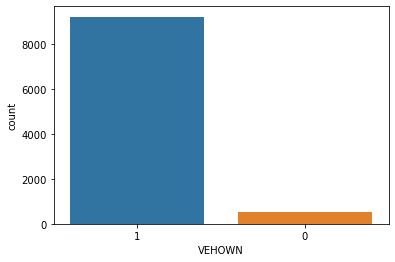

In [166]:
# check proportion of car ownership vs non-ownership
cat_col_prop(variables, 'VEHOWN')

In [167]:
#use local dataset
#variables = pd.read_csv('./hh_final_one_hot_encoding.csv')
#prep = variables.drop(columns = ['Unnamed: 0','HHFAMINC','WALK','TAXI','BIKE2SAVE','PTRANS','BUS','TRAIN','WALK2SAVE','HHRELATD','LIF_CYC','URBAN','URBANSIZE','HIGH_EDUC','HOMEOWN','WRKCOUNT_ratio','HHSIZE_cleaned','FT_ratio','WEBUSE17','PRICE','AVG_WORK_DIST','one_job','flexible_work'])

In [169]:
prep = variables.drop(columns = ['HHFAMINC','WALK','TAXI','BIKE2SAVE','PTRANS','BUS','TRAIN','WALK2SAVE','HHRELATD','LIF_CYC','URBAN','URBANSIZE','HIGH_EDUC','HOMEOWN','WRKCOUNT_ratio','HHSIZE_cleaned','FT_ratio','WEBUSE17','PRICE','AVG_WORK_DIST','one_job','flexible_work'])
#households = pd.read_csv('./data/hhpub.csv')
NY_households = households[households['HHSTATE'] == 'NY']
prep

,HOUSEID,VEHOWN,CNTTDHH,DRVRCNTPROP_binned,HHFAMINC_1,HHFAMINC_2,HHFAMINC_3,HHFAMINC_4,HHFAMINC_5,HHFAMINC_6,HHFAMINC_7,HHFAMINC_8,HHFAMINC_9,HHFAMINC_10,HHFAMINC_11,HHFAMINC_NA,WALK_1,WALK_2,WALK_3,WALK_4,WALK_5,WALK_NA,TAXI_1,TAXI_2,TAXI_3,TAXI_4,TAXI_5,TAXI_NA,BUS_1,BUS_2,BUS_3,BUS_4,BUS_5,BUS_NA,TRAIN_1,TRAIN_2,TRAIN_3,TRAIN_4,TRAIN_5,TRAIN_NA,PRICE_1,PRICE_2,PRICE_3,PRICE_4,PRICE_5,PRICE_NA,WALK2SAVE_1,WALK2SAVE_2,WALK2SAVE_3,WALK2SAVE_4,WALK2SAVE_5,WALK2SAVE_NA,BIKE2SAVE_1,BIKE2SAVE_2,BIKE2SAVE_3,BIKE2SAVE_4,BIKE2SAVE_5,BIKE2SAVE_NA,PTRANS_1,PTRANS_2,PTRANS_3,PTRANS_4,PTRANS_5,PTRANS_NA,HIGH_EDUC_1,HIGH_EDUC_2,HIGH_EDUC_3,HIGH_EDUC_4,HIGH_EDUC_5,HIGH_EDUC_NA,HOMEOWN_HOME_OWN,HOMEOWN_HOME_RENT,HOMEOWN_NA,WEBUSE17_Daily,WEBUSE17_NA,WEBUSE17_Never,WEBUSE17_Rarely,WRKCOUNT_ratio_1,WRKCOUNT_ratio_<0.5,WRKCOUNT_ratio_>0.5,HHSIZE_cleaned_1,HHSIZE_cleaned_2,HHSIZE_cleaned_>2,FT_ratio_0,FT_ratio_0.5,FT_ratio_1,FT_ratio_<0.5,FT_ratio_>0.5,FT_ratio_NA,FT_ratio_non-work,one_job_0,one_job_0.5,one_job_1,one_job_<0.5,one_job_>0.5,flexible_work_0,flexible_work_0.5,flexible_work_1,flexible_work_<0.5,flexible_work_>0.5,flexible_work_NA,flexible_work_non-work,DRVRCNTPROP_binned_0,DRVRCNTPROP_binned_0.5,DRVRCNTPROP_binned_1,DRVRCNTPROP_binned_<0.5,DRVRCNTPROP_binned_>0.5,URBANSIZE_1,URBANSIZE_2,URBANSIZE_3,URBANSIZE_5,URBANSIZE_6,URBAN_1,URBAN_2,URBAN_3,URBAN_4,HHRELATD_1,HHRELATD_2,LIF_CYC_1,LIF_CYC_2,LIF_CYC_3,LIF_CYC_4,LIF_CYC_5,LIF_CYC_6,LIF_CYC_7,LIF_CYC_8,LIF_CYC_9,LIF_CYC_10
0,30000012,1,9,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,30000082,1,12,0.5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,30000130,1,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,30000380,1,18,>0.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,30000434,1,6,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17169,40792952,1,15,>0.5,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
17170,40793204,1,8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
17171,40793555,1,13,>0.5,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,

In [170]:
hhsize = NY_households[['HOUSEID','HHSIZE']].copy()
hhtrip = prep[['HOUSEID','CNTTDHH']].copy()
hh_trip = hhtrip.merge(hhsize, on = 'HOUSEID', how = 'left')

           counts  percentage
2.000000     1235   12.638150
3.000000     1002   10.253786
4.000000      904    9.250921
5.000000      686    7.020057
6.000000      458    4.686860
...           ...         ...
12.500000       1    0.010233
9.250000        1    0.010233
3.571429        1    0.010233
5.428571        1    0.010233
2.285714        1    0.010233

[149 rows x 2 columns]


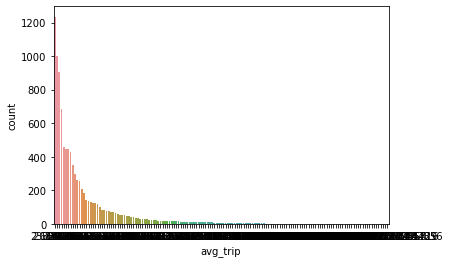

In [171]:
hh_trip['avg_trip'] = hh_trip['CNTTDHH']/hh_trip['HHSIZE']

cat_col_prop(hh_trip, 'avg_trip')

             counts  percentage
2 - 5 trips    4780   48.915268
<=2 trips      3005   30.751126
> 5 trips      1987   20.333606


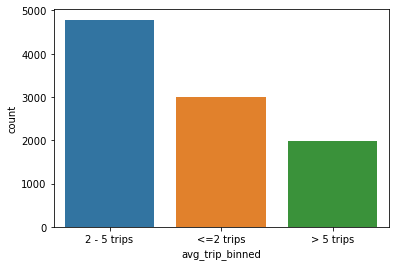

In [172]:
bins = [0, 2, 5, 100]
bins_label = ['<=2 trips','2 - 5 trips','> 5 trips']
hh_trip['avg_trip_binned'] = pd.cut(hh_trip['avg_trip'], bins, labels = bins_label,include_lowest=True)

cat_col_prop(hh_trip,'avg_trip_binned')

In [173]:
hh_trip_final = hh_trip[['HOUSEID','avg_trip_binned','avg_trip']]
prep = prep.merge(hh_trip_final, on ='HOUSEID', how = 'left')

In [174]:
df_one_hot = pd.get_dummies(prep['avg_trip_binned'])
prep_final = pd.concat([prep, df_one_hot], axis = 1)
prep_final = prep_final.drop(columns =['avg_trip_binned','CNTTDHH','DRVRCNTPROP_binned','avg_trip'])
prep_final

,HOUSEID,VEHOWN,HHFAMINC_1,HHFAMINC_2,HHFAMINC_3,HHFAMINC_4,HHFAMINC_5,HHFAMINC_6,HHFAMINC_7,HHFAMINC_8,HHFAMINC_9,HHFAMINC_10,HHFAMINC_11,HHFAMINC_NA,WALK_1,WALK_2,WALK_3,WALK_4,WALK_5,WALK_NA,TAXI_1,TAXI_2,TAXI_3,TAXI_4,TAXI_5,TAXI_NA,BUS_1,BUS_2,BUS_3,BUS_4,BUS_5,BUS_NA,TRAIN_1,TRAIN_2,TRAIN_3,TRAIN_4,TRAIN_5,TRAIN_NA,PRICE_1,PRICE_2,PRICE_3,PRICE_4,PRICE_5,PRICE_NA,WALK2SAVE_1,WALK2SAVE_2,WALK2SAVE_3,WALK2SAVE_4,WALK2SAVE_5,WALK2SAVE_NA,BIKE2SAVE_1,BIKE2SAVE_2,BIKE2SAVE_3,BIKE2SAVE_4,BIKE2SAVE_5,BIKE2SAVE_NA,PTRANS_1,PTRANS_2,PTRANS_3,PTRANS_4,PTRANS_5,PTRANS_NA,HIGH_EDUC_1,HIGH_EDUC_2,HIGH_EDUC_3,HIGH_EDUC_4,HIGH_EDUC_5,HIGH_EDUC_NA,HOMEOWN_HOME_OWN,HOMEOWN_HOME_RENT,HOMEOWN_NA,WEBUSE17_Daily,WEBUSE17_NA,WEBUSE17_Never,WEBUSE17_Rarely,WRKCOUNT_ratio_1,WRKCOUNT_ratio_<0.5,WRKCOUNT_ratio_>0.5,HHSIZE_cleaned_1,HHSIZE_cleaned_2,HHSIZE_cleaned_>2,FT_ratio_0,FT_ratio_0.5,FT_ratio_1,FT_ratio_<0.5,FT_ratio_>0.5,FT_ratio_NA,FT_ratio_non-work,one_job_0,one_job_0.5,one_job_1,one_job_<0.5,one_job_>0.5,flexible_work_0,flexible_work_0.5,flexible_work_1,flexible_work_<0.5,flexible_work_>0.5,flexible_work_NA,flexible_work_non-work,DRVRCNTPROP_binned_0,DRVRCNTPROP_binned_0.5,DRVRCNTPROP_binned_1,DRVRCNTPROP_binned_<0.5,DRVRCNTPROP_binned_>0.5,URBANSIZE_1,URBANSIZE_2,URBANSIZE_3,URBANSIZE_5,URBANSIZE_6,URBAN_1,URBAN_2,URBAN_3,URBAN_4,HHRELATD_1,HHRELATD_2,LIF_CYC_1,LIF_CYC_2,LIF_CYC_3,LIF_CYC_4,LIF_CYC_5,LIF_CYC_6,LIF_CYC_7,LIF_CYC_8,LIF_CYC_9,LIF_CYC_10,<=2 trips,2 - 5 trips,> 5 trips
0,30000012,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
1,30000082,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,30000130,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,30000380,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,30000434,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9767,40792952,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
9768,40793204,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
9769,40793555,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0

In [175]:
prep_final.shape

(9772, 129)

## Model Implementation

In [176]:
np.random.seed(31415)
# shuffle the data 
prep_final = prep_final.reindex(np.random.permutation(prep_final.index)) 

# training variables
x = prep_final.drop(columns = ['HOUSEID','VEHOWN'])

# test variables 
y = np.array(prep_final[['VEHOWN']]).astype(int)

y = y.reshape(y.shape[0],)
x.shape, y.shape

((9772, 127), (9772,))

In [177]:
# split into train and test set
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=np.random.seed(1234))
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7817, 127), (1955, 127), (7817,), (1955,))

### 1. Without resampling

#### 1.1 Base model: Logistic Regression

In [178]:
estimator = linear_model.LogisticRegression(max_iter = 300, random_state=np.random.seed(1234))
estimator.fit(x_train, y_train)

# use the metrics to see - accuracy, recall, precision and F1 score
y_pred = estimator.predict(x_test)
print('Accuracy Score: ',round(metrics.accuracy_score(y_test, y_pred),3))
print('Precision (non-veh):',round(metrics.precision_score(1-y_test, 1-y_pred),3))
print('Recall (non-veh):',round(metrics.recall_score(1-y_test, 1-y_pred),3))
print('F1 Score (non-veh):',round(metrics.f1_score(1-y_test, 1-y_pred),3))
print('AUC',round(metrics.roc_auc_score(y_test, y_pred),3))

sm_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_pred)}
"""
print(sm_report)
print('The classification report of Logistic Regression:\n {}'
      .format(metrics.classification_report(y_test, y_pred)))

Accuracy Score:  0.975
Precision (non-veh): 0.835
Recall (non-veh): 0.735
F1 Score (non-veh): 0.782
AUC 0.863

The evaluation report is:
Confusion Matrix:
[[  86   31]
 [  17 1821]]

The classification report of Logistic Regression:
               precision    recall  f1-score   support

           0       0.83      0.74      0.78       117
           1       0.98      0.99      0.99      1838

    accuracy                           0.98      1955
   macro avg       0.91      0.86      0.88      1955
weighted avg       0.97      0.98      0.97      1955



#### 1.2 Decision Tree

In [179]:
dt_estimator = tree.DecisionTreeClassifier(random_state=np.random.seed(1234))
dt_estimator.fit(x_train, y_train)
y_predict = dt_estimator.predict(x_test)

# Metrics for DT 
print('Accuracy Score: ',round(metrics.accuracy_score(y_test, y_predict),3))
print('Precision (non-veh):',round(metrics.precision_score(1-y_test, 1-y_predict),3))
print('Recall (non-veh):',round(metrics.recall_score(1-y_test, 1-y_predict),3))
print('F1 Score (non-veh):',round(metrics.f1_score(1-y_test, 1-y_predict),3))
print('AUC',round(metrics.roc_auc_score(1-y_test, 1-y_predict),3))

# Confusion Matrix for DT
y_predict = dt_estimator.predict(x_test)
report = f"""
The evaluation report of fully grown tree is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_predict)}
"""

print(report)
print('The classification report of Decision Tree Classifier:\n {}'
      .format(metrics.classification_report(y_test, y_predict)))

Accuracy Score:  0.963
Precision (non-veh): 0.689
Recall (non-veh): 0.701
F1 Score (non-veh): 0.695
AUC 0.84

The evaluation report of fully grown tree is:
Confusion Matrix:
[[  82   35]
 [  37 1801]]

The classification report of Decision Tree Classifier:
               precision    recall  f1-score   support

           0       0.69      0.70      0.69       117
           1       0.98      0.98      0.98      1838

    accuracy                           0.96      1955
   macro avg       0.84      0.84      0.84      1955
weighted avg       0.96      0.96      0.96      1955



In [180]:
# visualise the tree
x_columns = x.columns.to_list()
dot_data = export_graphviz(
        dt_estimator,
        out_file=None,
        feature_names=x_columns,
        class_names = ['non-car','car'],
        rounded=True,
        filled=True
    )

In [181]:
graph = graphviz.Source(dot_data, format="png") 
graph

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

In [182]:
graph.render("initial_tree")

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

#### 1.3 Cross-Fold Validation

In [ ]:
kf  = [
    model_selection.KFold(n_splits = 10),
    model_selection.StratifiedKFold(n_splits = 10),
    model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state=np.random.seed(1234))]

In [ ]:
x_new=pd.concat([x_train, x_test])
y_new=pd.concat([pd.Series(y_train), pd.Series(y_test)])

In [ ]:
clf = []
desc = []
for c in [1, 10, 100]:
    clf.append(linear_model.LogisticRegression(C = c, solver = 'liblinear'))
    desc.append('Logistic Regression with C = ' + str(c))

for d in [2, 3, 4]:
    clf.append(tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = d))
    desc.append('Decision Tree with depth = ' + str(d))

for i in range(6):
    print('------------------------')
    print(desc[i])
    print('------------------------')
    for j in range(3):
        print('**using ' + (j > 0 and 'Stratified' or '') + 'KFold' + (j == 2 and ' with shuffle' or ''))
        score = model_selection.cross_val_score(clf[i], x_new, y_new, scoring='accuracy', cv = kf[j])
        precision = model_selection.cross_val_score(clf[i], x_new, 1-y_new, scoring='precision', cv = kf[j])
        recall = model_selection.cross_val_score(clf[i], x_new, 1-y_new, scoring='recall', cv = kf[j])
        f1_score = model_selection.cross_val_score(clf[i], x_new, 1-y_new, scoring='f1', cv = kf[j])
        auc_score = model_selection.cross_val_score(clf[i], x_new, y_new, scoring='roc_auc', cv = kf[j])
        y_pred_cv = model_selection.cross_val_predict(clf[i], x_new, y_new, cv = kf[j])
        conf_mat_cv = metrics.confusion_matrix(y_new, y_pred_cv)
        print('        accuracy score:', score)
        print('        mean: %.3f, standard deviation: %.3f' % (np.mean(score), np.std(score)))
        print('        precision:', precision)
        print('        mean: %.3f, standard deviation: %.3f' % (np.mean(precision), np.std(precision)))
        print('        recall:', recall)
        print('        mean: %.3f, standard deviation: %.3f' % (np.mean(recall), np.std(recall)))
        print('        f1_score:', f1_score)
        print('        mean: %.3f, standard deviation: %.3f' % (np.mean(f1_score), np.std(f1_score)))
        print('        AUC:', auc_score)
        print('        mean: %.3f, standard deviation: %.3f' % (np.mean(auc_score), np.std(auc_score)))
        report_cv = f"""
        Confusion Matrix:\n
        {conf_mat_cv}\n
        """
        print(report_cv)
        print('The classification report of CV:\n {}'
              .format(metrics.classification_report(y_new, y_pred_cv)))

### 2. Oversampling using imblearn

In [ ]:
# apply only to train set
# summarize class distribution
print("Before oversampling: ",Counter(y_train))

# define oversampling strategy
SMOTE = SMOTE()

# fit and apply the transform
x_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(x_train, y_train)

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

#### 2.1 Logistic Regression with Oversampling

In [ ]:
# LR with oversampling
estimator_lr = linear_model.LogisticRegression(max_iter=300, random_state=np.random.seed(1234))
estimator_lr.fit(x_train_SMOTE, y_train_SMOTE)
y_lr_over = estimator_lr.predict(x_test)

# use the metrics to see - accuracy, recall, precision and F1 score
print('Accuracy Score:',round(metrics.accuracy_score(y_test, y_lr_over),3))
print('Precision (non-veh):', round(metrics.precision_score(1-y_test, 1-y_lr_over),3))
print('Recall (non-veh):', round(metrics.recall_score(1-y_test, 1-y_lr_over),3))
print('F1 Score (non-veh):',round(metrics.recall_score(y_test, y_lr_over),3))
print('AUC:',round(metrics.roc_auc_score(y_test, y_lr_over),3))

sm_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_lr_over)}
Accuracy: {round(metrics.accuracy_score(y_test, y_lr_over), 3)}
"""
print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_lr_over)))

#### 2.2 Decision Tree with Oversampling

In [ ]:
dt_smote = tree.DecisionTreeClassifier(random_state=np.random.seed(1234))
dt_smote.fit(x_train_SMOTE, y_train_SMOTE)
y_pred_smote = dt_smote.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, y_pred_smote),3))
print('Precision (non-car):', round(metrics.precision_score(1-y_test, 1-y_pred_smote),3))
print('Recall (non-car):', round(metrics.recall_score(1-y_test, 1-y_pred_smote),3))
print('F1 Score (non-car):',round(metrics.recall_score(y_test, y_pred_smote),3))
print('AUC:',round(metrics.roc_auc_score(y_test, y_pred_smote),3))

sm_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_pred_smote)}
"""
print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_pred_smote)))

### 3. Undersampling using imblearn

In [ ]:
under = RandomUnderSampler()

# fit and apply the transform
x_train_under, y_train_under = under.fit_resample(x_train, y_train)

# summarize class distribution
print("Before oversampling: ",Counter(y_train))
print("After oversampling: ",Counter(y_train_under))

#### 3.1 Logistic Regression with Undersampling

In [ ]:
estimator_lr = linear_model.LogisticRegression(max_iter = 300, random_state=np.random.seed(1234))
estimator_lr.fit(x_train_under, y_train_under)
y_lr_under = estimator_lr.predict(x_test)

# use the metrics to see - accuracy, recall, precision and F1 score
print('Accuracy Score: ',round(metrics.accuracy_score(y_test, y_lr_under),3))
print('Precision (non-veh)', round(metrics.precision_score(1-y_test, 1-y_lr_under),3))
print('Recall (non-veh)', round(metrics.recall_score(1-y_test, 1-y_lr_under),3))
print('F1 Score (non-veh):',round(metrics.recall_score(y_test, y_lr_under),3))
print('AUC',round(metrics.roc_auc_score(y_test, y_lr_under),3))

sm_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_lr_under)}
"""

print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_lr_under)))

#### 3.2 Decision Tree with Undersampling

In [ ]:
dt_under = tree.DecisionTreeClassifier(random_state=np.random.seed(1234))
dt_under.fit(x_train_under, y_train_under)
y_pred_under = dt_under.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, y_pred_under),3))
print('Precision (non-car):', round(metrics.precision_score(1-y_test, 1-y_pred_under),3))
print('Recall (non-car):', round(metrics.recall_score(1-y_test, 1-y_pred_under),3))
print('F1 Score (non-car):',round(metrics.recall_score(y_test, y_pred_under),3))
print('AUC:',round(metrics.roc_auc_score(y_test, y_pred_under),3))

sm_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_pred_under)}
"""
print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_pred_under)))

### 4. Boosting without sampling

#### 4.1 Random Forest

In [ ]:
# Random Forest Model
rf_car = ensemble.RandomForestClassifier(max_depth = 20, random_state=np.random.seed(1234), min_samples_split = 10, min_samples_leaf = 3, n_estimators = 100,class_weight='balanced')
rf_car.fit(x_train, y_train)
y_rf_pred = rf_car.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, y_rf_pred),3))
print('precision (non-car):', round(metrics.precision_score(1-y_test, 1-y_rf_pred),3))
print('recall (non-car):', round(metrics.recall_score(1-y_test, 1-y_rf_pred),3))
print('F1 Score (non-car):',round(metrics.recall_score(y_test, y_rf_pred),3))
print('AUC',round(metrics.roc_auc_score(y_test, y_rf_pred),3))

sm_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_rf_pred)}
"""

print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_rf_pred)))

#### 4.2 Gradient Boosting

In [ ]:
# Gradient Boost Model
gb_car = ensemble.GradientBoostingClassifier(n_estimators = 10, random_state=np.random.seed(1234))
gb_car.fit(x_train, y_train)
y_gb_car = gb_car.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, y_gb_car),3))
print('precision (non-car):', round(metrics.precision_score(1-y_test, 1-y_gb_car),3))
print('recall (non-car):', round(metrics.recall_score(1-y_test, 1-y_gb_car),3))
print('F1 Score (non-car):',round(metrics.recall_score(y_test, y_gb_car),3))
print('AUC',round(metrics.roc_auc_score(y_test, y_gb_car),3))

sm_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_gb_car)}
"""

print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_gb_car)))

#### 4.3 AdaBoost

In [ ]:
ada_car = ensemble.AdaBoostClassifier(random_state=np.random.seed(1234), learning_rate = 0.3, n_estimators=300)
ada_car.fit(x_train, y_train)
y_ada = ada_car.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, y_ada),3))
print('precision (non-car):', round(metrics.precision_score(1-y_test, 1-y_ada),3))
print('recall (non-car):', round(metrics.recall_score(1-y_test, 1-y_ada),3))
print('F1 Score (non-car):',round(metrics.recall_score(y_test, y_ada),3))
print('AUC',round(metrics.roc_auc_score(y_test, y_ada),3))

m_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_ada)}
"""

print(m_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_ada)))

#### 4.4 CatBoost

In [ ]:
cat_boost = CatBoostClassifier(verbose = 0, random_state=np.random.seed(1234))
cat_boost.fit(x_train, y_train)
cat_y = cat_boost.predict(x_test)

print('Accuracy: ',round(metrics.accuracy_score(y_test, cat_y),3))
print('precision (non-car):', round(metrics.precision_score(1-y_test, 1-cat_y),3))
print('recall (non-car):', round(metrics.recall_score(1-y_test, 1-cat_y),3))
print('F1 Score (non-car):',round(metrics.recall_score(y_test, cat_y),3))
print('AUC:',round(metrics.roc_auc_score(y_test, cat_y),3))

m_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, cat_y)}
"""

print(m_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, cat_y)))

### 5. Boosting with Oversampling

#### 5.1 Random Forest with Oversampling

In [ ]:
rf_smote = ensemble.RandomForestClassifier(max_depth = 20, random_state=np.random.seed(1234), min_samples_split = 10, min_samples_leaf = 3, n_estimators = 100)
rf_smote.fit(x_train_SMOTE, y_train_SMOTE)
y_rf_pred_over = rf_smote.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, y_rf_pred_over),3))
print('precision (non-car):', round(metrics.precision_score(1-y_test, 1-y_rf_pred_over),3))
print('recall (non-car):', round(metrics.recall_score(1-y_test, 1-y_rf_pred_over),3))
print('F1 Score (non-car):',round(metrics.recall_score(y_test, y_rf_pred_over),3))
print('AUC:',round(metrics.roc_auc_score(y_test, y_rf_pred_over),3))

sm_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_rf_pred_over)}
"""

print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_rf_pred_over)))

#### 5.2 Gradient Boosting with Oversampling

In [ ]:
gb_car_smote = ensemble.GradientBoostingClassifier(n_estimators = 10, random_state=np.random.seed(1234))
gb_car_smote.fit(x_train_SMOTE, y_train_SMOTE)
y_gb_car_over = gb_car_smote.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, y_gb_car_over),3))
print('precision (non-car):', round(metrics.precision_score(1-y_test, 1-y_gb_car_over),3))
print('recall (non-car):', round(metrics.recall_score(1-y_test, 1-y_gb_car_over),3))
print('F1 Score(non-car):',round(metrics.recall_score(y_test, y_gb_car_over),3))
print('AUC:',round(metrics.roc_auc_score(y_test, y_gb_car_over),3))

sm_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_gb_car_over)}
"""

print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_gb_car_over)))

#### 5.3 AdaBoost with Oversampling

In [ ]:
ada_car_smote = ensemble.AdaBoostClassifier(random_state=np.random.seed(1234), learning_rate = 0.3, n_estimators=300)
ada_car_smote.fit(x_train_SMOTE, y_train_SMOTE)
y_ada_over = ada_car_smote.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, y_ada_over),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_ada_over),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_ada_over),3))
print('F1 Score on non-car:',round(metrics.recall_score(y_test, y_ada_over),3))
print('AUC:',round(metrics.roc_auc_score(y_test, y_ada_over),3))

m_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_ada_over)}
"""

print(m_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_ada_over)))

#### 5.4 CatBoost with Oversampling

In [ ]:
cat_over = CatBoostClassifier(verbose = 0,random_state=np.random.seed(1234))
cat_over.fit(x_train_SMOTE, y_train_SMOTE)
cat_y_over = cat_over.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, cat_y_over),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-cat_y_over),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-cat_y_over),3))
print('F1 Score:',round(metrics.recall_score(y_test, cat_y_over),3))
print('AUC:',round(metrics.roc_auc_score(y_test, cat_y_over),3))

m_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, cat_y_over)}
"""

print(m_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, cat_y_over)))

### 6. Boosting with Undersampling

#### 6.1 Random Forest with Undersampling

In [ ]:
rf_under = ensemble.RandomForestClassifier(max_depth = 20, random_state=np.random.seed(1234), min_samples_split = 10, min_samples_leaf = 3, n_estimators = 100)
rf_under.fit(x_train_under, y_train_under)
y_rf_pred_under = rf_under.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, y_rf_pred_under),3))
print('precision (non-car):', round(metrics.precision_score(1-y_test, 1-y_rf_pred_under),3))
print('recall (non-car):', round(metrics.recall_score(1-y_test, 1-y_rf_pred_under),3))
print('F1 Score (non-car):',round(metrics.recall_score(y_test, y_rf_pred_under),3))
print('AUC:',round(metrics.roc_auc_score(y_test, y_rf_pred_under),3))

sm_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_rf_pred_under)}
"""

print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_rf_pred_under)))

#### 6.2 Gradient Boosting with Undersampling

In [ ]:
gb_car_under = ensemble.GradientBoostingClassifier(n_estimators = 10, random_state=np.random.seed(1234))
gb_car_under.fit(x_train_under, y_train_under)
y_gb_car_under = gb_car_under.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, y_gb_car_under),3))
print('precision (non-car):', round(metrics.precision_score(1-y_test, 1-y_gb_car_under),3))
print('recall (non-car):', round(metrics.recall_score(1-y_test, 1-y_gb_car_under),3))
print('F1 Score (non-car):',round(metrics.recall_score(y_test, y_gb_car_under),3))
print('AUC:',round(metrics.roc_auc_score(y_test, y_gb_car_under),3))

sm_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_gb_car_under)}
"""

print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_gb_car_under)))

#### 6.3 AdaBoost with Undersampling

In [ ]:
# Adaboost
ada_car_under= ensemble.AdaBoostClassifier(random_state=2021, learning_rate = 0.3, n_estimators=300)
ada_car_under.fit(x_train_under, y_train_under)
y_ada_under = ada_car_under.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, y_ada_under),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_ada_under),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_ada_under),3))
print('F1 Score:',round(metrics.recall_score(y_test, y_ada_under),3))
print('AUC:',round(metrics.roc_auc_score(y_test, y_ada_under),3))

m_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_ada_under)}
"""

print(m_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, y_ada_under)))

#### 6.4 CatBoost with Undersampling

In [ ]:
cat_under = CatBoostClassifier(verbose = 0,random_state=np.random.seed(1234) )
cat_under.fit(x_train_under, y_train_under)
cat_y_under = cat_under.predict(x_test)

print('Accuracy Score:',round(metrics.accuracy_score(y_test, cat_y_under),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-cat_y_under),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-cat_y_under),3))
print('F1 Score:',round(metrics.recall_score(y_test, cat_y_under),3))
print('AUC:',round(metrics.roc_auc_score(y_test, cat_y_under),3))

m_report = f"""
The evaluation report is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, cat_y_under)}
"""

print(m_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, cat_y_under)))

### 7. Hyperparameter Tuning of Models

In [ ]:
# split the train data further to validation and test data
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=np.random.seed(1234))
X_train_over, X_val_over, Y_train_over, Y_val_over = model_selection.train_test_split(x_train_SMOTE, y_train_SMOTE, test_size=0.2, random_state=np.random.seed(1234))
X_train_under, X_val_under, Y_train_under, Y_val_under = model_selection.train_test_split(x_train_under, y_train_under, test_size=0.2, random_state=np.random.seed(1234))

#### 7.1 Tuning of Random Forest Model

In [ ]:
## Tuning of RF Model
# Orignal data
parameters = {'n_estimators': [10,20,30,40,50,60],
              'max_features': ['auto', 'sqrt'],
              'max_depth': np.arange(5, 36, 5),
              'min_samples_split': [5, 10, 20, 40],
              'min_samples_leaf': [3, 5, 11, 25],
             }

rf_tune = RandomizedSearchCV(RandomForestClassifier(), param_distributions = parameters, n_iter = 100, verbose = 2, n_jobs = -1, random_state=np.random.seed(1234))
rf_tune.fit(X_train, Y_train)
y_rf_tune = rf_tune.predict(x_test)

print('best score:', rf_tune.best_score_)
print('best parameters: ', rf_tune.best_params_)

print('AUC:',round(metrics.roc_auc_score(y_test, y_rf_tune),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_rf_tune),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_rf_tune),3))

m_report = f"""
The evaluation report is:
Confusion Matrix (Test):
{metrics.confusion_matrix(y_test, y_rf_tune)}
"""
print(m_report)

In [ ]:
## Tuning of RF Model
# Oversampled Data
rf_tune_over = RandomizedSearchCV(RandomForestClassifier(random_state=np.random.seed(1234)), param_distributions = parameters, n_iter = 100, verbose = 2, scoring = 'precision', n_jobs = -1,random_state=np.random.seed(1234))
rf_tune_over.fit(X_train_over, Y_train_over)
y_rft_over = rf_tune_over.predict(x_test)

print('best score:', rf_tune_over.best_score_)
print('best parameters: ', rf_tune_over.best_params_)

print('AUC:',round(metrics.roc_auc_score(y_test, y_rft_over),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_rft_over),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_rft_over),3))

m_report = f"""
The evaluation report is:
Confusion Matrix (Test):
{metrics.confusion_matrix(y_test, y_rft_over)}
"""
print(m_report)

In [ ]:
## Tuning of RF Model
# Undersampled Data
rf_tune_under = RandomizedSearchCV(RandomForestClassifier(random_state=np.random.seed(1234)), param_distributions = parameters, n_iter = 100, verbose = 2, scoring = 'recall', n_jobs = -1,random_state=np.random.seed(1234))
rf_tune_under.fit(X_train_under, Y_train_under)
y_rft_under = rf_tune_under.predict(x_test)

print('best score:', rf_tune_under.best_score_)
print('best parameters: ', rf_tune_under.best_params_)

print('AUC:',round(metrics.roc_auc_score(y_test, y_rft_under),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_rft_under),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_rft_under),3))

m_report = f"""
The evaluation report is:
Confusion Matrix (Test):
{metrics.confusion_matrix(y_test, y_rft_under)}
"""
print(m_report)

#### 7.2 Tuning of Gradient Boosting Model

In [ ]:
## Tuning of Gradient Boosting Model
# Original Data
param_grid = {'n_estimators': [20,50,100],
              "learning_rate"    : [0.1, 0.3,0.5],
              "max_depth"        : [10, 20,30],
              "min_samples_split": [10,20,30],
              "min_samples_leaf" : [5,7,11],
              "max_leaf_nodes": [3,5,7,10]
             }

grad_tune = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions = param_grid, n_iter = 100, scoring = 'precision', verbose = 10, n_jobs = -1,random_state=np.random.seed(1234))
grad_tune.fit(X_train,Y_train)
y_grad = grad_tune.predict(x_test)

print('best score:', grad_tune.best_score_)
print('best parameters: ', grad_tune.best_params_)

print('AUC:',round(metrics.roc_auc_score(y_test, y_grad),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_grad),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_grad),3))

m_report = f"""
The evaluation report is:
Confusion Matrix (Test):
{metrics.confusion_matrix(y_test, y_grad)}
"""
print(m_report)

In [ ]:
## Tuning of Gradient Boosting Model
# Oversampled Data
grad_tune_over = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions = param_grid, n_iter = 100, scoring = 'precision', verbose = 10, n_jobs = -1,random_state=np.random.seed(1234))
grad_tune_over.fit(X_train_over,Y_train_over)
y_gover = grad_tune_over.predict(x_test)

print('best score:', grad_tune_over.best_score_)
print('best parameters: ', grad_tune_over.best_params_)

print('AUC:',round(metrics.roc_auc_score(y_test, y_gover),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_gover),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_gover),3))

m_report = f"""
The evaluation report is:
Confusion Matrix (Test):
{metrics.confusion_matrix(y_test, y_gover)}
"""
print(m_report)

In [ ]:
## Tuning of Gradient Boosting Model
# Undersampled Data
grad_tune_under = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions = param_grid, n_iter = 100, scoring = 'precision', verbose = 10, n_jobs = -1,random_state=np.random.seed(1234))
grad_tune_under.fit(X_train_under,Y_train_under)
y_gunder = grad_tune_under.predict(x_test)

print('best score:', grad_tune_under.best_score_)
print('best parameters: ', grad_tune_under.best_params_)

print('AUC:',round(metrics.roc_auc_score(y_test, y_gunder),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_gunder),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_gunder),3))

m_report = f"""
The evaluation report is:
Confusion Matrix (Test):
{metrics.confusion_matrix(y_test, y_gunder)}
"""
print(m_report)

#### 7.3 Tuning of AdaBoost Model

In [ ]:
## Tuning of AdaBoost Model
# Original Data
param_grid = {'n_estimators': [50,100],
              "learning_rate" : [0.01,0.05, 0.1, 0.3],
             }
ada_reg = RandomizedSearchCV(AdaBoostClassifier(), param_distributions = param_grid, n_iter = 100,scoring = 'precision', verbose = 2, n_jobs = -1,random_state=np.random.seed(1234))
ada_reg.fit(X_train, Y_train)
y_ad = ada_reg.predict(x_test)

print('best score:', ada_reg.best_score_)
print('best parameters: ', ada_reg.best_params_)

print('AUC:',round(metrics.roc_auc_score(y_test, y_ad),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_ad),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_ad),3))

m_report = f"""
The evaluation report is:
Confusion Matrix (Test):
{metrics.confusion_matrix(y_test, y_ad)}
"""
print(m_report)

In [ ]:
## Tuning of AdaBoost Model
# Oversampled Data
ada_over = RandomizedSearchCV(AdaBoostClassifier(), param_distributions = param_grid, n_iter = 100, verbose = 2, n_jobs = -1,random_state=np.random.seed(1234))
ada_over.fit(X_train_over, Y_train_over)
y_adover = ada_over.predict(x_test)

print('best score:', ada_over.best_score_)
print('best parameters: ', ada_over.best_params_)

print('AUC:',round(metrics.roc_auc_score(y_test, y_adover),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_adover),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_adover),3))

m_report = f"""
The evaluation report is:
Confusion Matrix (Test):
{metrics.confusion_matrix(y_test, y_adover)}
"""
print(m_report)

In [ ]:
## Tuning of AdaBoost Model
# Undersampled Data
ada_under = RandomizedSearchCV(AdaBoostClassifier(), param_distributions = param_grid, n_iter = 100, verbose = 2, n_jobs = -1,random_state=np.random.seed(1234))
ada_under.fit(X_train_under, Y_train_under)
y_adunder = ada_under.predict(x_test)

print('best score:', ada_under.best_score_)
print('best parameters: ', ada_under.best_params_)

print('AUC:',round(metrics.roc_auc_score(y_test, y_adunder),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_adunder),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_adunder),3))

m_report = f"""
The evaluation report is:
Confusion Matrix (Test):
{metrics.confusion_matrix(y_test, y_adunder)}
"""
print(m_report)

#### 7.4 Tuning of CatBoost Model

In [ ]:
## Tuning of CatBoost Model
# Original Data
param_grid = {'n_estimators': [100,150,200],
              "learning_rate"    : [0.1, 0.3,0.5,0.65,0.7],
              "max_depth"        : [5,10,20]
             }

cat_tune = RandomizedSearchCV(CatBoostClassifier(verbose = 0), param_distributions = param_grid, n_iter = 100, verbose = 10, n_jobs = -1,random_state=np.random.seed(1234))
cat_tune.fit(X_train,Y_train)
y_cat = cat_tune.predict(x_test)

print('best score:', cat_tune.best_score_)
print('best parameters: ', cat_tune.best_params_)

print('AUC:',round(metrics.roc_auc_score(y_test, y_cat),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_cat),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_cat),3))

m_report = f"""
The evaluation report is:
Confusion Matrix (Test):
{metrics.confusion_matrix(y_test, y_cat)}
"""
print(m_report)

In [ ]:
## Tuning of CatBoost Model
# Oversampled Data
cat_tune_over = RandomizedSearchCV(CatBoostClassifier(verbose = 0), param_distributions = param_grid, n_iter = 100, verbose = 10, n_jobs = -1,random_state=np.random.seed(1234))
cat_tune_over.fit(X_train_over,Y_train_over)
y_catover = cat_tune_over.predict(x_test)

print('best score:', cat_tune_over.best_score_)
print('best parameters: ', cat_tune_over.best_params_)

print('AUC:',round(metrics.roc_auc_score(y_test, y_catover),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_catover),3))
print('recall on non-car:', round(metrics.recall_score(1-y_test, 1-y_catover),3))

m_report = f"""
The evaluation report is:
Confusion Matrix (Test):
{metrics.confusion_matrix(y_test, y_catover)}
"""
print(m_report)

In [ ]:
## Tuning of CatBoost Model
# Undersampled Data
cat_tune_under = RandomizedSearchCV(CatBoostClassifier(verbose = 0), param_distributions = param_grid, n_iter = 100, scoring = 'precision', verbose = 10, n_jobs = -1,random_state=np.random.seed(1234))
cat_tune_under.fit(X_train_under,Y_train_under)
y_catunder = cat_tune_under.predict(x_test)

print('best score:', cat_tune_under.best_score_)
print('best parameters: ', cat_tune_under.best_params_)

print('AUC:',round(metrics.roc_auc_score(y_test, y_catunder),3))
print('precision on non-car:', round(metrics.precision_score(1-y_test, 1-y_catunder),3))
print('recall on non-ca:r', round(metrics.recall_score(1-y_test, 1-y_catunder),3))

m_report = f"""
The evaluation report is:
Confusion Matrix (Test):
{metrics.confusion_matrix(y_test, y_catunder)}
"""
print(m_report)

## Model Explainability

In [ ]:
# Feature Importance for Random Forest Tuned
x = rf_car.feature_importances_
x_idx = np.where(x != 0)[0]

rf_features = pd.DataFrame(x_train.columns[x_idx], columns = ['Car Variables'])
x_values = pd.DataFrame(rf_car.feature_importances_[x_idx], columns = ['Feature Importance'])
car_importance = pd.concat([rf_features.reset_index(drop=True), x_values], axis=1)
car_importance.nlargest(10,['Feature Importance'])

In [ ]:
shap_values = shap.TreeExplainer(rf_car).shap_values(x_train)
shap.summary_plot(shap_values[0], x_train, max_display = 20) # for non-vehicle

In [ ]:
shap.summary_plot(shap_values, x_train, max_display = 20)